# Tel-Aviv Deep Learning Boot-camp: 12 Applied Deep Learning Labs

## Lab 0: Plant Seedlings Classification (PyTorch): The most basic lab :)  

<img src="assets/seedlings.png" align="center">

### Instructors:

- Shlomo Kashani: shlomo@bayesian.io ,
- Nathaniel Shimoni nathaniel.shimoni@grid4c.com 

<img src="assets/pt.jpg" width="35%" align="center">

## Progress

- [x] PyTorch DataSet
- [x] PyTorch DataLoader
- [x] Augmentations
- [x] Simple CNN
- [x] Training + train test split
- [x] TensorBoard Support from PyTorch
- [x] Accuray and Log Loss
- [x] Tqdm progress
- [x] Persisting the model
- [x] Testing on a test set



### Links:

- https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/ 
- Git: https://github.com/bayesianio/applied-dl-2018
- Full info: https://www.evernote.com/shard/s341/sh/3855640e-2b0b-42e5-b5b9-00216d02ac9a/b47968226e49a81ee813901cd41d3924

### Date and Location: 
- July 2018


### Requirements:
- Python 3.5, CUDA 9, cuDNN 7, PyTorch 2.0 or above, Keras 2 or above

#### For Windows 10 and Windows Server 2016, CUDA 9
`conda install -c peterjc123 pytorch cuda90`


### Data
- Download: https://www.kaggle.com/c/plant-seedlings-classification

- Please make sure you have already set up a Pytorch tree structure of your dataset:
- `data_dir= '/home/data/bone/train/' `

```
    data_dir= '/home/data/bone/train/
    
    ├── valid
    │   └── Type_1
        ├── Type_2
        └── Type_3
    └── train
        ├── Type_1
        ├── Type_2
        └── Type_3
```

### PyTorch Datasets

To create a dataset, we subclass Dataset and define a constructor, a `__len__` method, and a `__getitem__` method. 
Here is full example:

```python
class BoneDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0] # file name
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2] # category_id
        if self.transform:
            image = self.transform(image)
        return image, labels
```

### The PyTorch DataLoader Class¶
- Will load our BoneDataset
- Can be regarded as a list (or iterator, technically).
- Each time it is invoked will provide a minibatch of (img, label) pairs.


### Training with TensorBoard

With the aid of [Crayon](https://github.com/torrvision/crayon),
we can access the visualisation power of TensorBoard for any 
deep learning framework.

To use the TensorBoard, install Crayon (https://github.com/torrvision/crayon)
and set `use_tensorboard = True`


## Google Colab links:
- https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d
- https://jovianlin.io/pytorch-with-gpu-in-google-colab/

In [2]:
# Google specific code

# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
# !pip3 install torchvision
# !pip3 install tqdm

# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# !mkdir -p med-drive
# !google-drive-ocamlfuse med-drive

In [3]:
%reset -f 
%matplotlib inline


import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 


import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)



__Python VERSION: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
__pyTorch VERSION: 0.3.1.post2
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:32_Central_Daylight_Time_2017
Cuda compilation tools, release 9.0, V9.0.176
__CUDNN VERSION: 7003
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
USE CUDA=True


In [4]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from kmodels import *
from kdataset import *

### Define Custom Dataset

In [5]:
import os
dataset='seedlings' # bone , cat-dog   d:/db/data/cat-dog/train/ ISIC2017
data_dir= 'd:/db/data/' +  dataset + '/train/'
# data_dir_valid= 'd:/db/data/' +  dataset + '/valid/'

classes, class_to_idx, num_to_class, df =GenericDataset.find_classes (data_dir )

print (classes)
print (class_to_idx)
print (num_to_class)
df.head(5)    

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
{0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}


,file,category,category_id
0,Black-grass/0050f38b3.png,Black-grass,0
1,Black-grass/0183fdf68.png,Black-grass,0
2,Black-grass/0260cffa8.png,Black-grass,0
3,Black-grass/05eedce4d.png,Black-grass,0
4,Black-grass/075d004bc.png,Black-grass,0


In [6]:
len(classes)

12

# Target distribution : Train set

c:\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


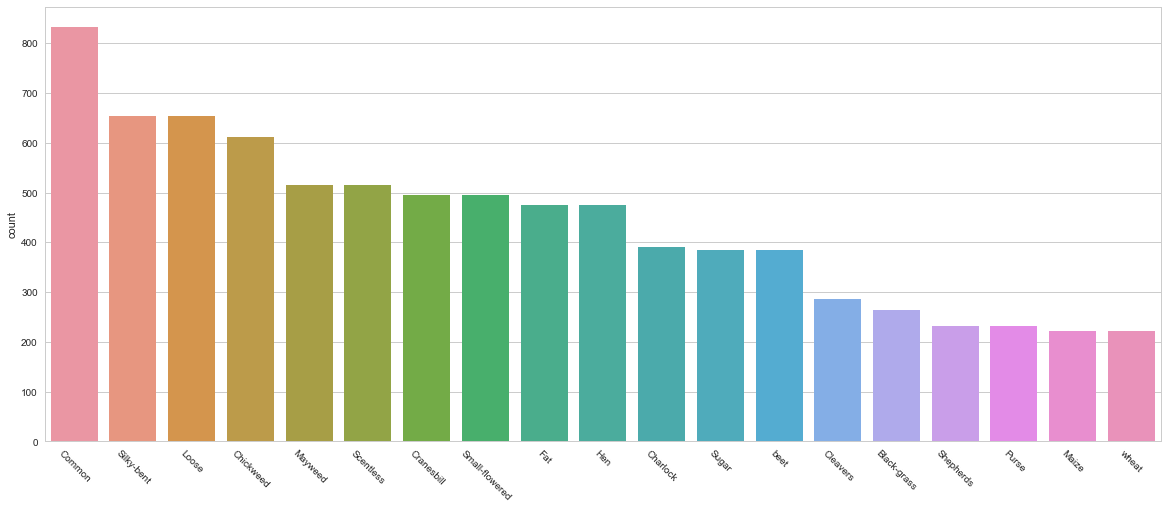

In [7]:
import seaborn as sns
sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

labels = df['category'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(20,8)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-45);

# Augmentation 

In [8]:
from __future__ import absolute_import

from torchvision.transforms import *

from PIL import Image, ImageDraw
import numpy as np
import torch

import torchvision
import random
from PIL import Image, ImageOps
import numpy as np
import numbers
import math
import torch
import torch
import random
import PIL.ImageEnhance as ie
import PIL.Image as im

# adapted from https://github.com/kuangliu/pytorch-retinanet/blob/master/transform.py
# https://github.com/mratsim/Amazon-Forest-Computer-Vision/blob/master/src/p_data_augmentation.py

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

from ktransforms import *

## Setup transforms, datasets, and dataloaders

- Data loaders spit out data from a dataset in batches. This is what you actually feed the neural network during training.

{'train': 4038, 'valid': 712}
6     544
3     512
8     441
10    427
5     406
11    336
1     333
2     249
0     220
9     195
4     195
7     180
Name: category_id, dtype: int64


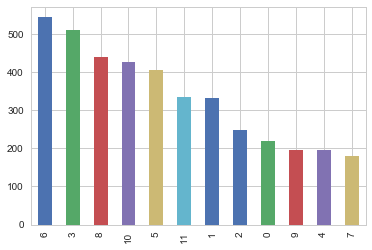

In [9]:
image_size = 224

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_trans = transforms.Compose([
    transforms.RandomSizedCrop(image_size),
    PowerPIL(),
    transforms.ToTensor(),
#     normalize_img,
    RandomErasing()
])

## Normalization only for validation and test
valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
#     normalize_img
])

batch_size = 8
train_data = df.sample(frac=0.85)
valid_data = df[~df['file'].isin(train_data['file'])]

train_set = GenericDataset(train_data, data_dir, transform = train_trans)
valid_set = GenericDataset(valid_data, data_dir, transform = valid_trans)
        

t_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
v_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
# test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(t_loader.dataset), 
    'valid': len(v_loader.dataset)
}


print (dataset_sizes)
print (train_data["category_id"].value_counts())

train_data['category_id'].value_counts().plot(kind='bar')

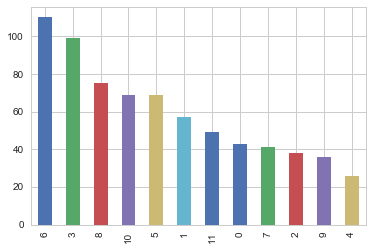

In [10]:
valid_data['category_id'].value_counts().plot(kind='bar')

### Test the DataLoader Class

i=0: 
i=1: 
i=2: 
i=3: 


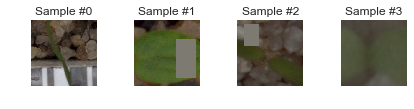

In [11]:
imagesToShow=4

def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    

if __name__ == '__main__':  
    for i, data in enumerate(t_loader, 0):
        print('i=%d: '%(i))            
        images, labels = data            
        num = len(images)

        ax = plt.subplot(1, imagesToShow, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')

        for n in range(num):
            image=images[n]
            label=labels[n]
            plt.imshow (flaotTensorToImage(image))

        if i==imagesToShow-1:
            break

## Define the model
- A simple CNN with great performance (95% accuracy) 
- In PyTorch, a model is defined by a subclass of nn.Module. It has two methods:

`__init__:` constructor. Create layers here. Note that we don't define the connections between layers in this function.

`forward(x):` forward function. Receives an input variable x. Returns a output variable. Note that we actually connect the layers here dynamically.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np

model = SimpleNet(len(classes), 3)
# model =vggnetXX_generic(len(classes), 3)
# model =lenetXX_generic(len(classes), 3)
# model =resnetxtXX_generic(len(classes), 3)
# model =wrnXX_generic(len(classes), 3)
# model = senetXX_generic(len(classes), 3, 32)


criterion = torch.nn.CrossEntropyLoss()
lr= 0.00005 * 2 * 2
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

if use_cuda:
    model = model.cuda()
# model = senetXX_generic(len(classes), 3, 32)
model_name = (type(model).__name__) # remember the real name
# model = torch.nn.DataParallel(model, device_ids=list(range(4)))
print(model)

SimpleNet(
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (cnn1): ConvCNN(
    (math): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.01)
      (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), dilation=(1, 1), ceil_mode=False)
    )
    (avgpool): AvgPool2d(kernel_size=4, stride=4, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (cnn2): ConvCNN(
    (math): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.01)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (cnn3): ConvCNN(
    (math): Sequential(
      (0): Conv2d(64, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2,

# Metrics and Tensorboard

In [13]:
import datetime 

from utils import *

NOW_TIME = datetime.datetime.now()
NOW_TIME =NOW_TIME.strftime("%Y-%m-%d %H:%M")

use_tensorboard=False

hms_string(1000)

'0:16:40.00'

### Training

In [14]:
from tqdm import tqdm 
from sklearn import metrics
import torch
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

def train(train_loader, model, epoch, optimizer):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
   
    # switch to train mode
    model.train()

    end = time.time()
    for batch_idx, (images, target) in enumerate(train_loader): 
        correct = 0
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            images, target = images.cuda(), target.cuda()
            images, target = Variable(images), Variable(target)
        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, target)

        # measure accuracy and record loss
        prec1, prec1 = accuracy2(y_pred.data, target.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))
        
        pred = y_pred.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 200  == 0:
            print('TRAIN: LOSS-->{loss.val:.4f} ({loss.avg:.4f})\t' 'ACC-->{acc.val:.3f}% ({acc.avg:.3f}%)'.format(loss=losses, acc=acc))
            if use_tensorboard:
                exp.add_scalar_value('tr_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('tr_epoch_acc', acc.avg, step=epoch)
                
            print('TRAIN: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.3f}%)'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0],
                correct, len(images),
                accuracy))            
    

    return float('{loss.avg:.4f}'.format(loss=losses)), float('{acc.avg:.4f}'.format(acc=acc))

def validate(val_loader, model, epoch):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(val_loader):

        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            images, labels = Variable(images, volatile=True), Variable(labels)

        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # measure accuracy and record loss
        prec1, temp_var = accuracy2(y_pred.data, labels.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 200== 0:
            print('VAL:   LOSS--> {loss.val:.4f} ({loss.avg:.4f})\t''ACC-->{acc.val:.3f} ({acc.avg:.3f})'.format(loss=losses, acc=acc))

        if i % 50 == 0:
            if use_tensorboard:
                exp.add_scalar_value('val_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('val_epoch_acc', acc.avg, step=epoch)

    print(' * Accuracy {acc.avg:.4f}'.format(acc=acc))
    return float('{loss.avg:.6f}'.format(loss=losses)), float('{acc.avg:.6f}'.format(acc=acc))


def testImageLoader(image_name):
    """load image, returns cuda tensor"""
#     image = Image.open(image_name)
    image = Image.open(image_name).convert('RGB')
    image = test_trans(image)
#     image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  
    if use_cuda:
#         print ("cuda")
        image.cuda()         
    return image  

def testModel(test_dir, local_model):    
    if use_cuda:
        local_model.cuda()
    
    local_model.eval()
    
    columns = ['file', 'species']
    df_pred = pd.DataFrame(data=np.zeros((0, len(columns))), columns=columns)
#     df_pred.species.astype(int)
    for index, row in (sample_submission.iterrows()):
#         for file in os.listdir(test_dir):            
        currImage=os.path.join(test_dir, row['file'])
        if os.path.isfile(currImage):
            X_tensor_test=testImageLoader (currImage)            
#             print (type(X_tensor_test))
            if use_cuda:
                X_tensor_test = Variable(X_tensor_test.cuda()) 
            else:
                X_tensor_test = Variable(X_tensor_test)        
            
            # get the index of the max log-probability
            predicted_val = (local_model(X_tensor_test)).data.max(1)[1] # get the index of the max log-probability
#             predicted_val = predicted_val.data.max(1, keepdim=True)[1]
            p_test = (predicted_val.cpu().numpy().item())
            df_pred = df_pred.append({'file': row['file'], 'species': num_to_class[int(p_test)]}, ignore_index=True)             
    
    return df_pred

c:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
test_trans = valid_trans
test_data_dir = 'd:/db/data/seedlings/test/'

### Train the model

In [0]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.columns = ['file', 'species']
# sample_submission['category_id'] = 0
sample_submission.head(3)

if __name__ == '__main__':  
    epochs=150
    runId = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')    
    recorder = RecorderMeter(epochs)  # epoc is updated
#     model_name = (type(model).__name__)

    exp_name = datetime.datetime.now().strftime(model_name + '_' + dataset + '_%Y-%m-%d_%H-%M-%S')    
    mPath = './logs' + '/' + dataset + '/' + model_name + '/'    
    if not os.path.isdir(mPath):
        os.makedirs(mPath)    
    print("Random Seed: {}".format(manualSeed))
    print("python version : {}".format(sys.version.replace('\n', ' ')))
    print("torch  version : {}".format(torch.__version__))
    print("cudnn  version : {}".format(torch.backends.cudnn.version()))    
    print("=> Final model name '{}'".format(model_name))            
    print ("MODEL: {}".format( str(model_name)))
    print ("dataset: {}".format(dataset))
    print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))    
    
    print ("MODEL: {}".format( str(type(model).__name__)))
    
    start_training_time = time.time()
    training_time=time.time()
    for epoch in tqdm(range(0, epochs)):        
        train_result, accuracy_tr=train(t_loader, model, epoch, optimizer)
        val_loss, val_accuracy= validate(v_loader, model, epoch)  
        
        recorder.update(epoch, train_result, accuracy_tr, val_loss, val_accuracy) 
        training_time=time.time() - start_training_time
        recorder.plot_curve(os.path.join(mPath, model_name + '_' + exp_name + '.png'),training_time, model, model_name,
                            str(dataset_sizes),
                        batch_size, lr,dataset,manualSeed,len(classes))
        
        if float(val_accuracy) > float(95.0):            
            print ("EARLY STOP")            
            df_pred=testModel(test_data_dir,model)
            df_pred.to_csv(str(type(model).__name__) + '_' + str(val_accuracy) + '_' + 
                           str(epoch) + "_sub.csv", columns=('file', 'species'), index=None)
            torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + '_.pth'))                        

Random Seed: 999
python version : 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
torch  version : 0.3.1.post2
cudnn  version : 7003
=> Final model name 'SimpleNet'
MODEL: SimpleNet
dataset: seedlings
    Total params: 1.09M
MODEL: SimpleNet


  0%|                                                                                                                                                           | 0/150 [00:00<?, ?it/s]

TRAIN: LOSS-->2.4626 (2.4626)	ACC-->12.500% (12.500%)
TRAIN: 0 [0/4038 (0%)]	Loss: 2.462649, Accuracy: 1/8 (12.500%)
TRAIN: LOSS-->2.2186 (2.2714)	ACC-->0.000% (20.585%)
TRAIN: 0 [1600/4038 (40%)]	Loss: 2.218592, Accuracy: 0/8 (0.000%)
TRAIN: LOSS-->1.8370 (2.1620)	ACC-->37.500% (25.031%)
TRAIN: 0 [3200/4038 (79%)]	Loss: 1.836956, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 1.7921 (1.7921)	ACC-->37.500 (37.500)
 * Accuracy 36.0955


  1%|▉                                                                                                                                                | 1/150 [00:57<2:23:55, 57.95s/it]

TRAIN: LOSS-->1.5502 (1.5502)	ACC-->50.000% (50.000%)
TRAIN: 1 [0/4038 (0%)]	Loss: 1.550174, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.6645 (1.9592)	ACC-->50.000% (32.214%)
TRAIN: 1 [1600/4038 (40%)]	Loss: 1.664478, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.8693 (1.9161)	ACC-->25.000% (34.352%)
TRAIN: 1 [3200/4038 (79%)]	Loss: 1.869259, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 1.8869 (1.8869)	ACC-->25.000 (25.000)
 * Accuracy 45.9270


  1%|█▉                                                                                                                                               | 2/150 [01:54<2:21:22, 57.31s/it]

TRAIN: LOSS-->2.4967 (2.4967)	ACC-->0.000% (0.000%)
TRAIN: 2 [0/4038 (0%)]	Loss: 2.496723, Accuracy: 0/8 (0.000%)
TRAIN: LOSS-->1.1944 (1.8436)	ACC-->62.500% (36.256%)
TRAIN: 2 [1600/4038 (40%)]	Loss: 1.194419, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.9125 (1.8175)	ACC-->50.000% (37.313%)
TRAIN: 2 [3200/4038 (79%)]	Loss: 1.912515, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 1.6052 (1.6052)	ACC-->37.500 (37.500)
 * Accuracy 54.4944


  2%|██▉                                                                                                                                              | 3/150 [02:50<2:19:18, 56.86s/it]

TRAIN: LOSS-->1.9679 (1.9679)	ACC-->25.000% (25.000%)
TRAIN: 3 [0/4038 (0%)]	Loss: 1.967861, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.4986 (1.7065)	ACC-->25.000% (41.231%)
TRAIN: 3 [1600/4038 (40%)]	Loss: 1.498605, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.5248 (1.7141)	ACC-->37.500% (41.022%)
TRAIN: 3 [3200/4038 (79%)]	Loss: 1.524840, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 0.7172 (0.7172)	ACC-->75.000 (75.000)
 * Accuracy 65.3090


  3%|███▊                                                                                                                                             | 4/150 [03:47<2:18:07, 56.76s/it]

TRAIN: LOSS-->1.5049 (1.5049)	ACC-->50.000% (50.000%)
TRAIN: 4 [0/4038 (0%)]	Loss: 1.504925, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.5156 (1.7165)	ACC-->37.500% (41.480%)
TRAIN: 4 [1600/4038 (40%)]	Loss: 1.515593, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.3403 (1.6636)	ACC-->62.500% (42.893%)
TRAIN: 4 [3200/4038 (79%)]	Loss: 1.340322, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 1.5526 (1.5526)	ACC-->50.000 (50.000)
 * Accuracy 59.4101


  3%|████▊                                                                                                                                            | 5/150 [04:43<2:17:12, 56.78s/it]

TRAIN: LOSS-->1.4268 (1.4268)	ACC-->62.500% (62.500%)
TRAIN: 5 [0/4038 (0%)]	Loss: 1.426771, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1804 (1.5625)	ACC-->62.500% (47.699%)
TRAIN: 5 [1600/4038 (40%)]	Loss: 1.180378, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.2801 (1.6041)	ACC-->62.500% (45.511%)
TRAIN: 5 [3200/4038 (79%)]	Loss: 1.280127, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.9937 (0.9937)	ACC-->75.000 (75.000)
 * Accuracy 63.7640


  4%|█████▊                                                                                                                                           | 6/150 [05:40<2:16:03, 56.69s/it]

TRAIN: LOSS-->1.1409 (1.1409)	ACC-->75.000% (75.000%)
TRAIN: 6 [0/4038 (0%)]	Loss: 1.140936, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.2346 (1.5754)	ACC-->75.000% (47.948%)
TRAIN: 6 [1600/4038 (40%)]	Loss: 1.234563, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.7549 (1.5717)	ACC-->25.000% (47.506%)
TRAIN: 6 [3200/4038 (79%)]	Loss: 1.754940, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 1.0586 (1.0586)	ACC-->87.500 (87.500)
 * Accuracy 62.6404


  5%|██████▊                                                                                                                                          | 7/150 [06:36<2:14:52, 56.59s/it]

TRAIN: LOSS-->1.3382 (1.3382)	ACC-->37.500% (37.500%)
TRAIN: 7 [0/4038 (0%)]	Loss: 1.338248, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.9508 (1.5514)	ACC-->25.000% (48.197%)
TRAIN: 7 [1600/4038 (40%)]	Loss: 1.950802, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.0730 (1.5181)	ACC-->62.500% (48.784%)
TRAIN: 7 [3200/4038 (79%)]	Loss: 1.072952, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.9543 (0.9543)	ACC-->75.000 (75.000)
 * Accuracy 70.2247


  5%|███████▋                                                                                                                                         | 8/150 [07:32<2:13:49, 56.54s/it]

TRAIN: LOSS-->1.6810 (1.6810)	ACC-->25.000% (25.000%)
TRAIN: 8 [0/4038 (0%)]	Loss: 1.680982, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.4514 (1.4519)	ACC-->62.500% (51.244%)
TRAIN: 8 [1600/4038 (40%)]	Loss: 1.451371, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.4536 (1.4579)	ACC-->50.000% (51.621%)
TRAIN: 8 [3200/4038 (79%)]	Loss: 1.453572, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.5126 (0.5126)	ACC-->100.000 (100.000)
 * Accuracy 71.2079


  6%|████████▋                                                                                                                                        | 9/150 [08:28<2:12:43, 56.48s/it]

TRAIN: LOSS-->1.9498 (1.9498)	ACC-->25.000% (25.000%)
TRAIN: 9 [0/4038 (0%)]	Loss: 1.949806, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.8781 (1.4095)	ACC-->37.500% (52.488%)
TRAIN: 9 [1600/4038 (40%)]	Loss: 1.878124, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.7133 (1.4213)	ACC-->50.000% (52.338%)
TRAIN: 9 [3200/4038 (79%)]	Loss: 1.713297, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.5476 (0.5476)	ACC-->75.000 (75.000)
 * Accuracy 73.1742


  7%|█████████▌                                                                                                                                      | 10/150 [09:24<2:11:40, 56.43s/it]

TRAIN: LOSS-->1.8690 (1.8690)	ACC-->50.000% (50.000%)
TRAIN: 10 [0/4038 (0%)]	Loss: 1.868964, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.4736 (1.4174)	ACC-->50.000% (52.363%)
TRAIN: 10 [1600/4038 (40%)]	Loss: 1.473614, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.9720 (1.3692)	ACC-->62.500% (54.208%)
TRAIN: 10 [3200/4038 (79%)]	Loss: 0.972039, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 1.3083 (1.3083)	ACC-->62.500 (62.500)
 * Accuracy 69.3820


  7%|██████████▌                                                                                                                                     | 11/150 [10:20<2:10:39, 56.40s/it]

TRAIN: LOSS-->1.0247 (1.0247)	ACC-->62.500% (62.500%)
TRAIN: 11 [0/4038 (0%)]	Loss: 1.024666, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.0291 (1.3263)	ACC-->75.000% (56.219%)
TRAIN: 11 [1600/4038 (40%)]	Loss: 1.029093, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.9672 (1.3474)	ACC-->25.000% (55.549%)
TRAIN: 11 [3200/4038 (79%)]	Loss: 1.967248, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 0.7494 (0.7494)	ACC-->50.000 (50.000)
 * Accuracy 72.7528


  8%|███████████▌                                                                                                                                    | 12/150 [11:17<2:09:47, 56.43s/it]

TRAIN: LOSS-->1.2640 (1.2640)	ACC-->50.000% (50.000%)
TRAIN: 12 [0/4038 (0%)]	Loss: 1.263955, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->2.2035 (1.3099)	ACC-->25.000% (55.784%)
TRAIN: 12 [1600/4038 (40%)]	Loss: 2.203535, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.7212 (1.2943)	ACC-->62.500% (56.608%)
TRAIN: 12 [3200/4038 (79%)]	Loss: 1.721243, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.8413 (0.8413)	ACC-->62.500 (62.500)
 * Accuracy 78.5112


  9%|████████████▍                                                                                                                                   | 13/150 [12:13<2:08:55, 56.46s/it]

TRAIN: LOSS-->1.3922 (1.3922)	ACC-->62.500% (62.500%)
TRAIN: 13 [0/4038 (0%)]	Loss: 1.392226, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1158 (1.2620)	ACC-->50.000% (56.841%)
TRAIN: 13 [1600/4038 (40%)]	Loss: 1.115804, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.4239 (1.2733)	ACC-->62.500% (57.263%)
TRAIN: 13 [3200/4038 (79%)]	Loss: 1.423916, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.4325 (0.4325)	ACC-->100.000 (100.000)
 * Accuracy 77.6685


  9%|█████████████▍                                                                                                                                  | 14/150 [13:10<2:07:56, 56.44s/it]

TRAIN: LOSS-->1.5073 (1.5073)	ACC-->62.500% (62.500%)
TRAIN: 14 [0/4038 (0%)]	Loss: 1.507285, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7191 (1.2656)	ACC-->62.500% (56.841%)
TRAIN: 14 [1600/4038 (40%)]	Loss: 0.719141, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7843 (1.2608)	ACC-->87.500% (57.076%)
TRAIN: 14 [3200/4038 (79%)]	Loss: 0.784253, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.7840 (0.7840)	ACC-->50.000 (50.000)
 * Accuracy 79.0730


 10%|██████████████▍                                                                                                                                 | 15/150 [14:06<2:06:57, 56.42s/it]

TRAIN: LOSS-->1.3828 (1.3828)	ACC-->75.000% (75.000%)
TRAIN: 15 [0/4038 (0%)]	Loss: 1.382835, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6722 (1.2158)	ACC-->87.500% (59.017%)
TRAIN: 15 [1600/4038 (40%)]	Loss: 0.672237, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.6170 (1.2403)	ACC-->62.500% (58.229%)
TRAIN: 15 [3200/4038 (79%)]	Loss: 1.617047, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.7179 (0.7179)	ACC-->62.500 (62.500)
 * Accuracy 81.4607


 11%|███████████████▎                                                                                                                                | 16/150 [15:03<2:06:07, 56.48s/it]

TRAIN: LOSS-->0.4490 (0.4490)	ACC-->87.500% (87.500%)
TRAIN: 16 [0/4038 (0%)]	Loss: 0.448957, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.3418 (1.1944)	ACC-->25.000% (59.515%)
TRAIN: 16 [1600/4038 (40%)]	Loss: 1.341791, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.3005 (1.2112)	ACC-->50.000% (59.414%)
TRAIN: 16 [3200/4038 (79%)]	Loss: 1.300455, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 1.5624 (1.5624)	ACC-->37.500 (37.500)
 * Accuracy 77.3876


 11%|████████████████▎                                                                                                                               | 17/150 [16:02<2:05:27, 56.60s/it]

TRAIN: LOSS-->1.8151 (1.8151)	ACC-->50.000% (50.000%)
TRAIN: 17 [0/4038 (0%)]	Loss: 1.815126, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.8111 (1.1739)	ACC-->50.000% (59.017%)
TRAIN: 17 [1600/4038 (40%)]	Loss: 1.811092, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.1343 (1.1694)	ACC-->62.500% (59.507%)
TRAIN: 17 [3200/4038 (79%)]	Loss: 1.134268, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.3986 (0.3986)	ACC-->87.500 (87.500)
 * Accuracy 81.1798


 12%|█████████████████▎                                                                                                                              | 18/150 [16:59<2:04:36, 56.64s/it]

TRAIN: LOSS-->1.0492 (1.0492)	ACC-->75.000% (75.000%)
TRAIN: 18 [0/4038 (0%)]	Loss: 1.049178, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0494 (1.1599)	ACC-->62.500% (59.764%)
TRAIN: 18 [1600/4038 (40%)]	Loss: 1.049438, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.2365 (1.1391)	ACC-->50.000% (60.754%)
TRAIN: 18 [3200/4038 (79%)]	Loss: 1.236532, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.5513 (0.5513)	ACC-->62.500 (62.500)
 * Accuracy 83.4270


 13%|██████████████████▏                                                                                                                             | 19/150 [17:57<2:03:47, 56.70s/it]

TRAIN: LOSS-->0.6904 (0.6904)	ACC-->75.000% (75.000%)
TRAIN: 19 [0/4038 (0%)]	Loss: 0.690448, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.2390 (1.2117)	ACC-->75.000% (58.769%)
TRAIN: 19 [1600/4038 (40%)]	Loss: 1.238999, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.2322 (1.1717)	ACC-->50.000% (60.193%)
TRAIN: 19 [3200/4038 (79%)]	Loss: 1.232235, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.4695 (0.4695)	ACC-->87.500 (87.500)
 * Accuracy 81.3202


 13%|███████████████████▏                                                                                                                            | 20/150 [18:55<2:03:00, 56.77s/it]

TRAIN: LOSS-->1.8783 (1.8783)	ACC-->25.000% (25.000%)
TRAIN: 20 [0/4038 (0%)]	Loss: 1.878284, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->0.4423 (1.1132)	ACC-->100.000% (62.376%)
TRAIN: 20 [1600/4038 (40%)]	Loss: 0.442305, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.2060 (1.1323)	ACC-->62.500% (61.690%)
TRAIN: 20 [3200/4038 (79%)]	Loss: 1.206022, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.7453 (0.7453)	ACC-->75.000 (75.000)
 * Accuracy 82.5843


 14%|████████████████████▏                                                                                                                           | 21/150 [19:52<2:02:03, 56.77s/it]

TRAIN: LOSS-->0.8769 (0.8769)	ACC-->62.500% (62.500%)
TRAIN: 21 [0/4038 (0%)]	Loss: 0.876936, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.0051 (1.1068)	ACC-->75.000% (62.562%)
TRAIN: 21 [1600/4038 (40%)]	Loss: 1.005075, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7427 (1.1141)	ACC-->75.000% (62.188%)
TRAIN: 21 [3200/4038 (79%)]	Loss: 0.742672, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2853 (0.2853)	ACC-->87.500 (87.500)
 * Accuracy 76.6854


 15%|█████████████████████                                                                                                                           | 22/150 [20:48<2:01:02, 56.74s/it]

TRAIN: LOSS-->1.0220 (1.0220)	ACC-->62.500% (62.500%)
TRAIN: 22 [0/4038 (0%)]	Loss: 1.021990, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.2394 (1.0808)	ACC-->50.000% (65.050%)
TRAIN: 22 [1600/4038 (40%)]	Loss: 1.239409, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.7591 (1.0915)	ACC-->75.000% (64.214%)
TRAIN: 22 [3200/4038 (79%)]	Loss: 0.759086, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4011 (0.4011)	ACC-->87.500 (87.500)
 * Accuracy 83.1461


 15%|██████████████████████                                                                                                                          | 23/150 [21:44<2:00:02, 56.71s/it]

TRAIN: LOSS-->0.5982 (0.5982)	ACC-->62.500% (62.500%)
TRAIN: 23 [0/4038 (0%)]	Loss: 0.598175, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.9207 (1.0690)	ACC-->62.500% (62.873%)
TRAIN: 23 [1600/4038 (40%)]	Loss: 0.920657, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5068 (1.0687)	ACC-->87.500% (63.435%)
TRAIN: 23 [3200/4038 (79%)]	Loss: 0.506825, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2622 (0.2622)	ACC-->87.500 (87.500)
 * Accuracy 83.4270


 16%|███████████████████████                                                                                                                         | 24/150 [22:40<1:59:01, 56.68s/it]

TRAIN: LOSS-->0.8798 (0.8798)	ACC-->75.000% (75.000%)
TRAIN: 24 [0/4038 (0%)]	Loss: 0.879757, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.4529 (1.0486)	ACC-->37.500% (64.925%)
TRAIN: 24 [1600/4038 (40%)]	Loss: 1.452895, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.6522 (1.0530)	ACC-->75.000% (64.464%)
TRAIN: 24 [3200/4038 (79%)]	Loss: 0.652240, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.5063 (0.5063)	ACC-->75.000 (75.000)
 * Accuracy 84.4101


 17%|████████████████████████                                                                                                                        | 25/150 [23:36<1:58:02, 56.66s/it]

TRAIN: LOSS-->2.0045 (2.0045)	ACC-->37.500% (37.500%)
TRAIN: 25 [0/4038 (0%)]	Loss: 2.004522, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.8776 (1.0507)	ACC-->50.000% (64.988%)
TRAIN: 25 [1600/4038 (40%)]	Loss: 0.877601, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.2111 (1.0441)	ACC-->62.500% (64.651%)
TRAIN: 25 [3200/4038 (79%)]	Loss: 1.211060, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2004 (0.2004)	ACC-->100.000 (100.000)
 * Accuracy 86.3764


 17%|████████████████████████▉                                                                                                                       | 26/150 [24:32<1:57:02, 56.63s/it]

TRAIN: LOSS-->1.1893 (1.1893)	ACC-->50.000% (50.000%)
TRAIN: 26 [0/4038 (0%)]	Loss: 1.189336, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.5799 (1.0427)	ACC-->37.500% (65.361%)
TRAIN: 26 [1600/4038 (40%)]	Loss: 1.579943, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.5995 (1.0438)	ACC-->75.000% (64.900%)
TRAIN: 26 [3200/4038 (79%)]	Loss: 0.599532, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2066 (0.2066)	ACC-->87.500 (87.500)
 * Accuracy 87.2191


 18%|█████████████████████████▉                                                                                                                      | 27/150 [25:28<1:56:04, 56.62s/it]

TRAIN: LOSS-->0.7645 (0.7645)	ACC-->75.000% (75.000%)
TRAIN: 27 [0/4038 (0%)]	Loss: 0.764484, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6977 (1.0534)	ACC-->75.000% (64.179%)
TRAIN: 27 [1600/4038 (40%)]	Loss: 0.697658, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.4274 (1.0228)	ACC-->37.500% (64.526%)
TRAIN: 27 [3200/4038 (79%)]	Loss: 1.427388, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 0.4127 (0.4127)	ACC-->75.000 (75.000)
 * Accuracy 85.8146


 19%|██████████████████████████▉                                                                                                                     | 28/150 [26:24<1:55:04, 56.60s/it]

TRAIN: LOSS-->0.5865 (0.5865)	ACC-->75.000% (75.000%)
TRAIN: 28 [0/4038 (0%)]	Loss: 0.586535, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9554 (0.9910)	ACC-->62.500% (66.045%)
TRAIN: 28 [1600/4038 (40%)]	Loss: 0.955401, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.0403 (1.0161)	ACC-->62.500% (65.461%)
TRAIN: 28 [3200/4038 (79%)]	Loss: 1.040284, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1693 (0.1693)	ACC-->100.000 (100.000)
 * Accuracy 86.9382


 19%|███████████████████████████▊                                                                                                                    | 29/150 [27:20<1:54:06, 56.58s/it]

TRAIN: LOSS-->0.9801 (0.9801)	ACC-->62.500% (62.500%)
TRAIN: 29 [0/4038 (0%)]	Loss: 0.980141, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5954 (1.0521)	ACC-->75.000% (64.179%)
TRAIN: 29 [1600/4038 (40%)]	Loss: 0.595394, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0585 (1.0350)	ACC-->75.000% (65.056%)
TRAIN: 29 [3200/4038 (79%)]	Loss: 1.058526, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1441 (0.1441)	ACC-->100.000 (100.000)
 * Accuracy 88.3427


 20%|████████████████████████████▊                                                                                                                   | 30/150 [28:16<1:53:07, 56.56s/it]

TRAIN: LOSS-->1.2097 (1.2097)	ACC-->62.500% (62.500%)
TRAIN: 30 [0/4038 (0%)]	Loss: 1.209712, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7933 (0.9963)	ACC-->62.500% (66.729%)
TRAIN: 30 [1600/4038 (40%)]	Loss: 0.793333, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.6063 (0.9972)	ACC-->62.500% (66.022%)
TRAIN: 30 [3200/4038 (79%)]	Loss: 1.606332, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.3290 (0.3290)	ACC-->87.500 (87.500)
 * Accuracy 86.2360


 21%|█████████████████████████████▊                                                                                                                  | 31/150 [29:12<1:52:08, 56.54s/it]

TRAIN: LOSS-->0.6695 (0.6695)	ACC-->75.000% (75.000%)
TRAIN: 31 [0/4038 (0%)]	Loss: 0.669510, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8150 (0.9687)	ACC-->50.000% (66.542%)
TRAIN: 31 [1600/4038 (40%)]	Loss: 0.815003, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.7655 (0.9705)	ACC-->87.500% (66.739%)
TRAIN: 31 [3200/4038 (79%)]	Loss: 0.765515, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1965 (0.1965)	ACC-->100.000 (100.000)
 * Accuracy 85.9551


 21%|██████████████████████████████▋                                                                                                                 | 32/150 [30:08<1:51:10, 56.53s/it]

TRAIN: LOSS-->0.3191 (0.3191)	ACC-->87.500% (87.500%)
TRAIN: 32 [0/4038 (0%)]	Loss: 0.319052, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.2224 (0.9770)	ACC-->50.000% (67.040%)
TRAIN: 32 [1600/4038 (40%)]	Loss: 1.222438, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4750 (1.0020)	ACC-->75.000% (66.397%)
TRAIN: 32 [3200/4038 (79%)]	Loss: 0.475014, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2012 (0.2012)	ACC-->100.000 (100.000)
 * Accuracy 89.4663


 22%|███████████████████████████████▋                                                                                                                | 33/150 [31:04<1:50:12, 56.51s/it]

TRAIN: LOSS-->0.9217 (0.9217)	ACC-->50.000% (50.000%)
TRAIN: 33 [0/4038 (0%)]	Loss: 0.921659, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.7186 (1.0108)	ACC-->62.500% (65.423%)
TRAIN: 33 [1600/4038 (40%)]	Loss: 0.718593, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.4985 (0.9820)	ACC-->50.000% (66.147%)
TRAIN: 33 [3200/4038 (79%)]	Loss: 1.498456, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.3537 (0.3537)	ACC-->87.500 (87.500)
 * Accuracy 88.0618


 23%|████████████████████████████████▋                                                                                                               | 34/150 [32:01<1:49:14, 56.50s/it]

TRAIN: LOSS-->1.2846 (1.2846)	ACC-->62.500% (62.500%)
TRAIN: 34 [0/4038 (0%)]	Loss: 1.284562, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2917 (0.9844)	ACC-->87.500% (67.164%)
TRAIN: 34 [1600/4038 (40%)]	Loss: 0.291662, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9792 (0.9570)	ACC-->75.000% (67.269%)
TRAIN: 34 [3200/4038 (79%)]	Loss: 0.979217, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1280 (0.1280)	ACC-->100.000 (100.000)
 * Accuracy 89.3258


 23%|█████████████████████████████████▌                                                                                                              | 35/150 [32:57<1:48:16, 56.49s/it]

TRAIN: LOSS-->0.6859 (0.6859)	ACC-->87.500% (87.500%)
TRAIN: 35 [0/4038 (0%)]	Loss: 0.685903, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.5026 (0.8982)	ACC-->50.000% (69.838%)
TRAIN: 35 [1600/4038 (40%)]	Loss: 1.502640, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4207 (0.9397)	ACC-->87.500% (67.706%)
TRAIN: 35 [3200/4038 (79%)]	Loss: 0.420662, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.7948 (0.7948)	ACC-->62.500 (62.500)
 * Accuracy 86.0955


 24%|██████████████████████████████████▌                                                                                                             | 36/150 [33:53<1:47:18, 56.48s/it]

TRAIN: LOSS-->1.4735 (1.4735)	ACC-->50.000% (50.000%)
TRAIN: 36 [0/4038 (0%)]	Loss: 1.473538, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.1284 (0.9556)	ACC-->62.500% (67.786%)
TRAIN: 36 [1600/4038 (40%)]	Loss: 1.128352, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6072 (0.9336)	ACC-->87.500% (67.955%)
TRAIN: 36 [3200/4038 (79%)]	Loss: 0.607241, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.6292 (0.6292)	ACC-->62.500 (62.500)
 * Accuracy 87.2191


 25%|███████████████████████████████████▌                                                                                                            | 37/150 [34:49<1:46:20, 56.47s/it]

TRAIN: LOSS-->0.8115 (0.8115)	ACC-->62.500% (62.500%)
TRAIN: 37 [0/4038 (0%)]	Loss: 0.811527, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.0558 (0.9373)	ACC-->62.500% (67.600%)
TRAIN: 37 [1600/4038 (40%)]	Loss: 1.055760, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3556 (0.9391)	ACC-->100.000% (67.488%)
TRAIN: 37 [3200/4038 (79%)]	Loss: 0.355620, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0848 (0.0848)	ACC-->100.000 (100.000)
 * Accuracy 87.3596


 25%|████████████████████████████████████▍                                                                                                           | 38/150 [35:45<1:45:22, 56.45s/it]

TRAIN: LOSS-->0.4478 (0.4478)	ACC-->87.500% (87.500%)
TRAIN: 38 [0/4038 (0%)]	Loss: 0.447768, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9428 (0.9431)	ACC-->50.000% (67.600%)
TRAIN: 38 [1600/4038 (40%)]	Loss: 0.942822, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.4454 (0.9182)	ACC-->50.000% (68.797%)
TRAIN: 38 [3200/4038 (79%)]	Loss: 1.445403, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.1383 (0.1383)	ACC-->100.000 (100.000)
 * Accuracy 88.3427


 26%|█████████████████████████████████████▍                                                                                                          | 39/150 [36:41<1:44:25, 56.44s/it]

TRAIN: LOSS-->0.7647 (0.7647)	ACC-->87.500% (87.500%)
TRAIN: 39 [0/4038 (0%)]	Loss: 0.764679, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4695 (0.9067)	ACC-->87.500% (69.030%)
TRAIN: 39 [1600/4038 (40%)]	Loss: 0.469496, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9498 (0.9071)	ACC-->62.500% (69.171%)
TRAIN: 39 [3200/4038 (79%)]	Loss: 0.949819, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2050 (0.2050)	ACC-->87.500 (87.500)
 * Accuracy 89.1854


 27%|██████████████████████████████████████▍                                                                                                         | 40/150 [37:37<1:43:27, 56.43s/it]

TRAIN: LOSS-->0.7753 (0.7753)	ACC-->62.500% (62.500%)
TRAIN: 40 [0/4038 (0%)]	Loss: 0.775346, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3055 (0.8895)	ACC-->100.000% (68.719%)
TRAIN: 40 [1600/4038 (40%)]	Loss: 0.305545, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.5490 (0.9183)	ACC-->62.500% (67.830%)
TRAIN: 40 [3200/4038 (79%)]	Loss: 1.548961, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1919 (0.1919)	ACC-->100.000 (100.000)
 * Accuracy 86.9382


 27%|███████████████████████████████████████▎                                                                                                        | 41/150 [38:33<1:42:30, 56.43s/it]

TRAIN: LOSS-->1.5229 (1.5229)	ACC-->50.000% (50.000%)
TRAIN: 41 [0/4038 (0%)]	Loss: 1.522866, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.5423 (0.8561)	ACC-->75.000% (70.833%)
TRAIN: 41 [1600/4038 (40%)]	Loss: 0.542294, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6840 (0.8981)	ACC-->75.000% (69.545%)
TRAIN: 41 [3200/4038 (79%)]	Loss: 0.684019, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2026 (0.2026)	ACC-->100.000 (100.000)
 * Accuracy 88.6236


 28%|████████████████████████████████████████▎                                                                                                       | 42/150 [39:29<1:41:33, 56.42s/it]

TRAIN: LOSS-->2.8402 (2.8402)	ACC-->50.000% (50.000%)
TRAIN: 42 [0/4038 (0%)]	Loss: 2.840188, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6816 (0.8914)	ACC-->75.000% (70.149%)
TRAIN: 42 [1600/4038 (40%)]	Loss: 0.681572, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.1477 (0.9003)	ACC-->62.500% (69.545%)
TRAIN: 42 [3200/4038 (79%)]	Loss: 1.147692, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0682 (0.0682)	ACC-->100.000 (100.000)
 * Accuracy 90.5899


 29%|█████████████████████████████████████████▎                                                                                                      | 43/150 [40:25<1:40:35, 56.41s/it]

TRAIN: LOSS-->0.7680 (0.7680)	ACC-->75.000% (75.000%)
TRAIN: 43 [0/4038 (0%)]	Loss: 0.767963, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9385 (0.9077)	ACC-->75.000% (68.159%)
TRAIN: 43 [1600/4038 (40%)]	Loss: 0.938529, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7694 (0.9120)	ACC-->62.500% (68.734%)
TRAIN: 43 [3200/4038 (79%)]	Loss: 0.769430, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.7376 (0.7376)	ACC-->62.500 (62.500)
 * Accuracy 87.9213


 29%|██████████████████████████████████████████▏                                                                                                     | 44/150 [41:21<1:39:38, 56.40s/it]

TRAIN: LOSS-->1.1837 (1.1837)	ACC-->62.500% (62.500%)
TRAIN: 44 [0/4038 (0%)]	Loss: 1.183664, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.7431 (0.8743)	ACC-->37.500% (69.154%)
TRAIN: 44 [1600/4038 (40%)]	Loss: 1.743141, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.0747 (0.8936)	ACC-->75.000% (69.358%)
TRAIN: 44 [3200/4038 (79%)]	Loss: 1.074668, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2195 (0.2195)	ACC-->87.500 (87.500)
 * Accuracy 90.5899


 30%|███████████████████████████████████████████▏                                                                                                    | 45/150 [42:17<1:38:41, 56.39s/it]

TRAIN: LOSS-->0.9590 (0.9590)	ACC-->75.000% (75.000%)
TRAIN: 45 [0/4038 (0%)]	Loss: 0.959012, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3928 (0.8299)	ACC-->100.000% (73.570%)
TRAIN: 45 [1600/4038 (40%)]	Loss: 0.392820, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.8720 (0.8303)	ACC-->50.000% (72.880%)
TRAIN: 45 [3200/4038 (79%)]	Loss: 0.871981, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.3800 (0.3800)	ACC-->75.000 (75.000)
 * Accuracy 91.0112


 31%|████████████████████████████████████████████▏                                                                                                   | 46/150 [43:13<1:37:44, 56.39s/it]

TRAIN: LOSS-->0.3633 (0.3633)	ACC-->87.500% (87.500%)
TRAIN: 46 [0/4038 (0%)]	Loss: 0.363307, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9705 (0.8747)	ACC-->62.500% (70.896%)
TRAIN: 46 [1600/4038 (40%)]	Loss: 0.970499, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.3779 (0.8733)	ACC-->50.000% (70.324%)
TRAIN: 46 [3200/4038 (79%)]	Loss: 1.377913, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.2570 (0.2570)	ACC-->100.000 (100.000)
 * Accuracy 89.3258


 31%|█████████████████████████████████████████████                                                                                                   | 47/150 [44:09<1:36:47, 56.38s/it]

TRAIN: LOSS-->0.8147 (0.8147)	ACC-->62.500% (62.500%)
TRAIN: 47 [0/4038 (0%)]	Loss: 0.814742, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5447 (0.8572)	ACC-->87.500% (70.274%)
TRAIN: 47 [1600/4038 (40%)]	Loss: 0.544743, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7078 (0.8573)	ACC-->75.000% (70.792%)
TRAIN: 47 [3200/4038 (79%)]	Loss: 0.707777, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.3565 (0.3565)	ACC-->75.000 (75.000)
 * Accuracy 86.3764


 32%|██████████████████████████████████████████████                                                                                                  | 48/150 [45:06<1:35:50, 56.38s/it]

TRAIN: LOSS-->0.8261 (0.8261)	ACC-->75.000% (75.000%)
TRAIN: 48 [0/4038 (0%)]	Loss: 0.826089, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8325 (0.8915)	ACC-->75.000% (69.527%)
TRAIN: 48 [1600/4038 (40%)]	Loss: 0.832455, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0865 (0.8608)	ACC-->62.500% (70.075%)
TRAIN: 48 [3200/4038 (79%)]	Loss: 1.086466, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.3460 (0.3460)	ACC-->87.500 (87.500)
 * Accuracy 91.2921


 33%|███████████████████████████████████████████████                                                                                                 | 49/150 [46:02<1:34:53, 56.37s/it]

TRAIN: LOSS-->0.3046 (0.3046)	ACC-->100.000% (100.000%)
TRAIN: 49 [0/4038 (0%)]	Loss: 0.304644, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4704 (0.8029)	ACC-->87.500% (72.886%)
TRAIN: 49 [1600/4038 (40%)]	Loss: 0.470435, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6183 (0.8245)	ACC-->62.500% (72.382%)
TRAIN: 49 [3200/4038 (79%)]	Loss: 0.618302, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2204 (0.2204)	ACC-->87.500 (87.500)
 * Accuracy 90.4494


 33%|████████████████████████████████████████████████                                                                                                | 50/150 [46:58<1:33:56, 56.37s/it]

TRAIN: LOSS-->0.2199 (0.2199)	ACC-->100.000% (100.000%)
TRAIN: 50 [0/4038 (0%)]	Loss: 0.219898, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1705 (0.8190)	ACC-->100.000% (71.517%)
TRAIN: 50 [1600/4038 (40%)]	Loss: 0.170474, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5262 (0.8246)	ACC-->75.000% (70.979%)
TRAIN: 50 [3200/4038 (79%)]	Loss: 0.526172, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1806 (0.1806)	ACC-->100.000 (100.000)
 * Accuracy 91.5730


 34%|████████████████████████████████████████████████▉                                                                                               | 51/150 [47:54<1:32:59, 56.36s/it]

TRAIN: LOSS-->0.5670 (0.5670)	ACC-->87.500% (87.500%)
TRAIN: 51 [0/4038 (0%)]	Loss: 0.566951, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5534 (0.7995)	ACC-->75.000% (71.766%)
TRAIN: 51 [1600/4038 (40%)]	Loss: 0.553421, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5687 (0.8408)	ACC-->62.500% (71.322%)
TRAIN: 51 [3200/4038 (79%)]	Loss: 0.568706, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0131 (0.0131)	ACC-->100.000 (100.000)
 * Accuracy 92.4157


 35%|█████████████████████████████████████████████████▉                                                                                              | 52/150 [48:50<1:32:02, 56.36s/it]

TRAIN: LOSS-->1.0824 (1.0824)	ACC-->62.500% (62.500%)
TRAIN: 52 [0/4038 (0%)]	Loss: 1.082435, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3211 (0.8331)	ACC-->87.500% (72.326%)
TRAIN: 52 [1600/4038 (40%)]	Loss: 0.321071, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7234 (0.8279)	ACC-->75.000% (72.444%)
TRAIN: 52 [3200/4038 (79%)]	Loss: 0.723374, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1460 (0.1460)	ACC-->100.000 (100.000)
 * Accuracy 90.0281


 35%|██████████████████████████████████████████████████▉                                                                                             | 53/150 [49:46<1:31:05, 56.35s/it]

TRAIN: LOSS-->0.8146 (0.8146)	ACC-->87.500% (87.500%)
TRAIN: 53 [0/4038 (0%)]	Loss: 0.814612, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3412 (0.8148)	ACC-->87.500% (72.015%)
TRAIN: 53 [1600/4038 (40%)]	Loss: 0.341212, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9748 (0.8274)	ACC-->75.000% (72.132%)
TRAIN: 53 [3200/4038 (79%)]	Loss: 0.974833, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.5482 (0.5482)	ACC-->75.000 (75.000)
 * Accuracy 87.9213


 36%|███████████████████████████████████████████████████▊                                                                                            | 54/150 [50:42<1:30:09, 56.34s/it]

TRAIN: LOSS-->1.3690 (1.3690)	ACC-->75.000% (75.000%)
TRAIN: 54 [0/4038 (0%)]	Loss: 1.368964, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9519 (0.8232)	ACC-->62.500% (71.455%)
TRAIN: 54 [1600/4038 (40%)]	Loss: 0.951921, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5366 (0.8129)	ACC-->87.500% (71.696%)
TRAIN: 54 [3200/4038 (79%)]	Loss: 0.536557, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.9524 (0.9524)	ACC-->75.000 (75.000)
 * Accuracy 89.4663


 37%|████████████████████████████████████████████████████▊                                                                                           | 55/150 [51:38<1:29:12, 56.34s/it]

TRAIN: LOSS-->0.8911 (0.8911)	ACC-->62.500% (62.500%)
TRAIN: 55 [0/4038 (0%)]	Loss: 0.891127, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1903 (0.7991)	ACC-->100.000% (71.828%)
TRAIN: 55 [1600/4038 (40%)]	Loss: 0.190291, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6829 (0.8154)	ACC-->75.000% (72.070%)
TRAIN: 55 [3200/4038 (79%)]	Loss: 0.682880, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.6150 (0.6150)	ACC-->75.000 (75.000)
 * Accuracy 91.5730


 37%|█████████████████████████████████████████████████████▊                                                                                          | 56/150 [52:34<1:28:15, 56.34s/it]

TRAIN: LOSS-->0.4007 (0.4007)	ACC-->87.500% (87.500%)
TRAIN: 56 [0/4038 (0%)]	Loss: 0.400745, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.8020 (0.7939)	ACC-->75.000% (72.326%)
TRAIN: 56 [1600/4038 (40%)]	Loss: 1.802005, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6456 (0.8018)	ACC-->87.500% (72.849%)
TRAIN: 56 [3200/4038 (79%)]	Loss: 0.645626, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0420 (0.0420)	ACC-->100.000 (100.000)
 * Accuracy 89.1854


 38%|██████████████████████████████████████████████████████▋                                                                                         | 57/150 [53:30<1:27:18, 56.33s/it]

TRAIN: LOSS-->1.7161 (1.7161)	ACC-->75.000% (75.000%)
TRAIN: 57 [0/4038 (0%)]	Loss: 1.716137, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9171 (0.7871)	ACC-->75.000% (73.072%)
TRAIN: 57 [1600/4038 (40%)]	Loss: 0.917066, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.3633 (0.8072)	ACC-->62.500% (73.036%)
TRAIN: 57 [3200/4038 (79%)]	Loss: 1.363256, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0806 (0.0806)	ACC-->100.000 (100.000)
 * Accuracy 90.0281


 39%|███████████████████████████████████████████████████████▋                                                                                        | 58/150 [54:26<1:26:21, 56.33s/it]

TRAIN: LOSS-->1.7938 (1.7938)	ACC-->25.000% (25.000%)
TRAIN: 58 [0/4038 (0%)]	Loss: 1.793836, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->0.4825 (0.8238)	ACC-->75.000% (70.585%)
TRAIN: 58 [1600/4038 (40%)]	Loss: 0.482478, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6300 (0.7993)	ACC-->75.000% (71.914%)
TRAIN: 58 [3200/4038 (79%)]	Loss: 0.630043, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2949 (0.2949)	ACC-->87.500 (87.500)
 * Accuracy 88.2022


 39%|████████████████████████████████████████████████████████▋                                                                                       | 59/150 [55:22<1:25:25, 56.32s/it]

TRAIN: LOSS-->0.6144 (0.6144)	ACC-->87.500% (87.500%)
TRAIN: 59 [0/4038 (0%)]	Loss: 0.614378, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5205 (0.8071)	ACC-->87.500% (72.948%)
TRAIN: 59 [1600/4038 (40%)]	Loss: 0.520465, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7533 (0.8024)	ACC-->62.500% (73.223%)
TRAIN: 59 [3200/4038 (79%)]	Loss: 0.753274, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1756 (0.1756)	ACC-->100.000 (100.000)
 * Accuracy 87.6404


 40%|█████████████████████████████████████████████████████████▌                                                                                      | 60/150 [56:18<1:24:28, 56.32s/it]

TRAIN: LOSS-->0.6731 (0.6731)	ACC-->62.500% (62.500%)
TRAIN: 60 [0/4038 (0%)]	Loss: 0.673123, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.2488 (0.7880)	ACC-->62.500% (73.694%)
TRAIN: 60 [1600/4038 (40%)]	Loss: 1.248761, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.9106 (0.7721)	ACC-->75.000% (73.878%)
TRAIN: 60 [3200/4038 (79%)]	Loss: 0.910623, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0942 (0.0942)	ACC-->100.000 (100.000)
 * Accuracy 92.4157


 41%|██████████████████████████████████████████████████████████▌                                                                                     | 61/150 [57:15<1:23:31, 56.31s/it]

TRAIN: LOSS-->0.5319 (0.5319)	ACC-->62.500% (62.500%)
TRAIN: 61 [0/4038 (0%)]	Loss: 0.531947, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.8920 (0.7877)	ACC-->62.500% (73.072%)
TRAIN: 61 [1600/4038 (40%)]	Loss: 0.892049, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7218 (0.7788)	ACC-->75.000% (73.410%)
TRAIN: 61 [3200/4038 (79%)]	Loss: 0.721760, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1325 (0.1325)	ACC-->100.000 (100.000)
 * Accuracy 89.7472


 41%|███████████████████████████████████████████████████████████▌                                                                                    | 62/150 [58:11<1:22:35, 56.31s/it]

TRAIN: LOSS-->0.2544 (0.2544)	ACC-->87.500% (87.500%)
TRAIN: 62 [0/4038 (0%)]	Loss: 0.254393, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5877 (0.7777)	ACC-->87.500% (74.005%)
TRAIN: 62 [1600/4038 (40%)]	Loss: 0.587678, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3922 (0.7945)	ACC-->87.500% (73.317%)
TRAIN: 62 [3200/4038 (79%)]	Loss: 0.392156, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1417 (0.1417)	ACC-->100.000 (100.000)
 * Accuracy 89.4663


 42%|████████████████████████████████████████████████████████████▍                                                                                   | 63/150 [59:07<1:21:38, 56.31s/it]

TRAIN: LOSS-->0.9730 (0.9730)	ACC-->62.500% (62.500%)
TRAIN: 63 [0/4038 (0%)]	Loss: 0.973021, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5962 (0.7874)	ACC-->75.000% (72.575%)
TRAIN: 63 [1600/4038 (40%)]	Loss: 0.596162, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.3692 (0.7841)	ACC-->62.500% (73.161%)
TRAIN: 63 [3200/4038 (79%)]	Loss: 1.369185, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0447 (0.0447)	ACC-->100.000 (100.000)
 * Accuracy 91.1517


 43%|████████████████████████████████████████████████████████████▌                                                                                 | 64/150 [1:00:03<1:20:42, 56.30s/it]

TRAIN: LOSS-->0.6366 (0.6366)	ACC-->75.000% (75.000%)
TRAIN: 64 [0/4038 (0%)]	Loss: 0.636553, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.5019 (0.7344)	ACC-->50.000% (75.311%)
TRAIN: 64 [1600/4038 (40%)]	Loss: 1.501929, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.7191 (0.7444)	ACC-->87.500% (74.813%)
TRAIN: 64 [3200/4038 (79%)]	Loss: 0.719058, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0964 (0.0964)	ACC-->100.000 (100.000)
 * Accuracy 91.4326


 43%|█████████████████████████████████████████████████████████████▌                                                                                | 65/150 [1:00:59<1:19:45, 56.30s/it]

TRAIN: LOSS-->1.7516 (1.7516)	ACC-->75.000% (75.000%)
TRAIN: 65 [0/4038 (0%)]	Loss: 1.751610, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5688 (0.7872)	ACC-->75.000% (73.010%)
TRAIN: 65 [1600/4038 (40%)]	Loss: 0.568828, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.3477 (0.7497)	ACC-->62.500% (73.784%)
TRAIN: 65 [3200/4038 (79%)]	Loss: 1.347692, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1309 (0.1309)	ACC-->100.000 (100.000)
 * Accuracy 92.6966


 44%|██████████████████████████████████████████████████████████████▍                                                                               | 66/150 [1:01:55<1:18:48, 56.29s/it]

TRAIN: LOSS-->0.9334 (0.9334)	ACC-->62.500% (62.500%)
TRAIN: 66 [0/4038 (0%)]	Loss: 0.933403, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1326 (0.7467)	ACC-->62.500% (74.751%)
TRAIN: 66 [1600/4038 (40%)]	Loss: 1.132551, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6455 (0.7544)	ACC-->75.000% (74.345%)
TRAIN: 66 [3200/4038 (79%)]	Loss: 0.645460, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1841 (0.1841)	ACC-->100.000 (100.000)
 * Accuracy 91.2921


 45%|███████████████████████████████████████████████████████████████▍                                                                              | 67/150 [1:02:51<1:17:52, 56.29s/it]

TRAIN: LOSS-->0.3920 (0.3920)	ACC-->87.500% (87.500%)
TRAIN: 67 [0/4038 (0%)]	Loss: 0.391993, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9291 (0.7644)	ACC-->50.000% (73.632%)
TRAIN: 67 [1600/4038 (40%)]	Loss: 0.929085, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.9286 (0.7307)	ACC-->75.000% (75.249%)
TRAIN: 67 [3200/4038 (79%)]	Loss: 0.928634, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2971 (0.2971)	ACC-->87.500 (87.500)
 * Accuracy 88.9045


 45%|████████████████████████████████████████████████████████████████▎                                                                             | 68/150 [1:03:47<1:16:55, 56.29s/it]

TRAIN: LOSS-->0.7604 (0.7604)	ACC-->75.000% (75.000%)
TRAIN: 68 [0/4038 (0%)]	Loss: 0.760424, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5556 (0.7879)	ACC-->87.500% (72.388%)
TRAIN: 68 [1600/4038 (40%)]	Loss: 0.555590, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8845 (0.7688)	ACC-->62.500% (72.880%)
TRAIN: 68 [3200/4038 (79%)]	Loss: 0.884534, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2014 (0.2014)	ACC-->87.500 (87.500)
 * Accuracy 88.2022


 46%|█████████████████████████████████████████████████████████████████▎                                                                            | 69/150 [1:04:43<1:15:59, 56.29s/it]

TRAIN: LOSS-->0.8028 (0.8028)	ACC-->75.000% (75.000%)
TRAIN: 69 [0/4038 (0%)]	Loss: 0.802759, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.4301 (0.7842)	ACC-->62.500% (73.072%)
TRAIN: 69 [1600/4038 (40%)]	Loss: 1.430095, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2504 (0.7717)	ACC-->100.000% (73.909%)
TRAIN: 69 [3200/4038 (79%)]	Loss: 0.250361, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.6432 (0.6432)	ACC-->75.000 (75.000)
 * Accuracy 91.2921


 47%|██████████████████████████████████████████████████████████████████▎                                                                           | 70/150 [1:05:39<1:15:02, 56.28s/it]

TRAIN: LOSS-->0.8776 (0.8776)	ACC-->62.500% (62.500%)
TRAIN: 70 [0/4038 (0%)]	Loss: 0.877639, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6364 (0.7164)	ACC-->75.000% (74.876%)
TRAIN: 70 [1600/4038 (40%)]	Loss: 0.636430, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.1775 (0.7216)	ACC-->50.000% (74.875%)
TRAIN: 70 [3200/4038 (79%)]	Loss: 1.177534, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.2242 (0.2242)	ACC-->87.500 (87.500)
 * Accuracy 89.6067


 47%|███████████████████████████████████████████████████████████████████▏                                                                          | 71/150 [1:06:35<1:14:06, 56.28s/it]

TRAIN: LOSS-->0.6708 (0.6708)	ACC-->75.000% (75.000%)
TRAIN: 71 [0/4038 (0%)]	Loss: 0.670837, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5226 (0.7457)	ACC-->87.500% (74.067%)
TRAIN: 71 [1600/4038 (40%)]	Loss: 0.522581, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.4518 (0.7540)	ACC-->50.000% (73.722%)
TRAIN: 71 [3200/4038 (79%)]	Loss: 1.451832, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.2384 (0.2384)	ACC-->87.500 (87.500)
 * Accuracy 90.4494


 48%|████████████████████████████████████████████████████████████████████▏                                                                         | 72/150 [1:07:31<1:13:09, 56.28s/it]

TRAIN: LOSS-->0.5879 (0.5879)	ACC-->87.500% (87.500%)
TRAIN: 72 [0/4038 (0%)]	Loss: 0.587885, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8063 (0.7033)	ACC-->62.500% (76.430%)
TRAIN: 72 [1600/4038 (40%)]	Loss: 0.806313, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2187 (0.7085)	ACC-->100.000% (76.153%)
TRAIN: 72 [3200/4038 (79%)]	Loss: 0.218692, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0827 (0.0827)	ACC-->100.000 (100.000)
 * Accuracy 89.3258


 49%|█████████████████████████████████████████████████████████████████████                                                                         | 73/150 [1:08:27<1:12:12, 56.27s/it]

TRAIN: LOSS-->0.4145 (0.4145)	ACC-->75.000% (75.000%)
TRAIN: 73 [0/4038 (0%)]	Loss: 0.414475, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5960 (0.7472)	ACC-->75.000% (73.445%)
TRAIN: 73 [1600/4038 (40%)]	Loss: 0.595966, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3771 (0.7382)	ACC-->87.500% (73.878%)
TRAIN: 73 [3200/4038 (79%)]	Loss: 0.377080, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1286 (0.1286)	ACC-->87.500 (87.500)
 * Accuracy 88.4831


 49%|██████████████████████████████████████████████████████████████████████                                                                        | 74/150 [1:09:24<1:11:16, 56.27s/it]

TRAIN: LOSS-->0.3037 (0.3037)	ACC-->87.500% (87.500%)
TRAIN: 74 [0/4038 (0%)]	Loss: 0.303693, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.2206 (0.7246)	ACC-->62.500% (75.746%)
TRAIN: 74 [1600/4038 (40%)]	Loss: 1.220645, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2895 (0.7506)	ACC-->87.500% (74.314%)
TRAIN: 74 [3200/4038 (79%)]	Loss: 0.289470, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2461 (0.2461)	ACC-->100.000 (100.000)
 * Accuracy 91.2921


 50%|███████████████████████████████████████████████████████████████████████                                                                       | 75/150 [1:10:20<1:10:20, 56.27s/it]

TRAIN: LOSS-->0.4704 (0.4704)	ACC-->87.500% (87.500%)
TRAIN: 75 [0/4038 (0%)]	Loss: 0.470445, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.5483 (0.7654)	ACC-->62.500% (74.316%)
TRAIN: 75 [1600/4038 (40%)]	Loss: 1.548285, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7103 (0.7306)	ACC-->62.500% (75.343%)
TRAIN: 75 [3200/4038 (79%)]	Loss: 0.710307, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0730 (0.0730)	ACC-->100.000 (100.000)
 * Accuracy 91.4326


 51%|███████████████████████████████████████████████████████████████████████▉                                                                      | 76/150 [1:11:16<1:09:23, 56.27s/it]

TRAIN: LOSS-->0.9867 (0.9867)	ACC-->50.000% (50.000%)
TRAIN: 76 [0/4038 (0%)]	Loss: 0.986748, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.5025 (0.6993)	ACC-->75.000% (76.182%)
TRAIN: 76 [1600/4038 (40%)]	Loss: 1.502534, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5804 (0.7139)	ACC-->62.500% (75.125%)
TRAIN: 76 [3200/4038 (79%)]	Loss: 0.580392, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0271 (0.0271)	ACC-->100.000 (100.000)
 * Accuracy 92.2753


 51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 77/150 [1:12:12<1:08:27, 56.26s/it]

TRAIN: LOSS-->0.9516 (0.9516)	ACC-->62.500% (62.500%)
TRAIN: 77 [0/4038 (0%)]	Loss: 0.951625, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.8819 (0.7555)	ACC-->62.500% (74.378%)
TRAIN: 77 [1600/4038 (40%)]	Loss: 0.881904, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.2664 (0.7302)	ACC-->50.000% (76.122%)
TRAIN: 77 [3200/4038 (79%)]	Loss: 1.266386, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.5494 (0.5494)	ACC-->87.500 (87.500)
 * Accuracy 91.9944


 52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 78/150 [1:13:08<1:07:30, 56.26s/it]

TRAIN: LOSS-->0.8677 (0.8677)	ACC-->75.000% (75.000%)
TRAIN: 78 [0/4038 (0%)]	Loss: 0.867654, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5916 (0.6898)	ACC-->87.500% (76.306%)
TRAIN: 78 [1600/4038 (40%)]	Loss: 0.591609, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9417 (0.6987)	ACC-->50.000% (76.278%)
TRAIN: 78 [3200/4038 (79%)]	Loss: 0.941669, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.0337 (0.0337)	ACC-->100.000 (100.000)
 * Accuracy 93.9607


 53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 79/150 [1:14:05<1:06:34, 56.27s/it]

TRAIN: LOSS-->0.8508 (0.8508)	ACC-->75.000% (75.000%)
TRAIN: 79 [0/4038 (0%)]	Loss: 0.850849, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5262 (0.7592)	ACC-->87.500% (73.445%)
TRAIN: 79 [1600/4038 (40%)]	Loss: 0.526222, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9397 (0.7304)	ACC-->62.500% (74.657%)
TRAIN: 79 [3200/4038 (79%)]	Loss: 0.939693, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.6606 (0.6606)	ACC-->75.000 (75.000)
 * Accuracy 91.2921


 53%|███████████████████████████████████████████████████████████████████████████▋                                                                  | 80/150 [1:15:01<1:05:38, 56.27s/it]

TRAIN: LOSS-->1.3558 (1.3558)	ACC-->62.500% (62.500%)
TRAIN: 80 [0/4038 (0%)]	Loss: 1.355764, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5996 (0.7022)	ACC-->87.500% (75.000%)
TRAIN: 80 [1600/4038 (40%)]	Loss: 0.599613, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5897 (0.7155)	ACC-->87.500% (74.688%)
TRAIN: 80 [3200/4038 (79%)]	Loss: 0.589654, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0550 (0.0550)	ACC-->100.000 (100.000)
 * Accuracy 93.3989


 54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 81/150 [1:15:57<1:04:42, 56.27s/it]

TRAIN: LOSS-->0.3816 (0.3816)	ACC-->87.500% (87.500%)
TRAIN: 81 [0/4038 (0%)]	Loss: 0.381559, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.0425 (0.6980)	ACC-->75.000% (75.498%)
TRAIN: 81 [1600/4038 (40%)]	Loss: 1.042532, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8732 (0.6856)	ACC-->75.000% (76.216%)
TRAIN: 81 [3200/4038 (79%)]	Loss: 0.873194, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4744 (0.4744)	ACC-->87.500 (87.500)
 * Accuracy 94.1011


 55%|█████████████████████████████████████████████████████████████████████████████▋                                                                | 82/150 [1:16:53<1:03:45, 56.26s/it]

TRAIN: LOSS-->0.3435 (0.3435)	ACC-->75.000% (75.000%)
TRAIN: 82 [0/4038 (0%)]	Loss: 0.343526, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.1028 (0.6903)	ACC-->50.000% (76.119%)
TRAIN: 82 [1600/4038 (40%)]	Loss: 1.102816, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.7188 (0.6969)	ACC-->62.500% (76.247%)
TRAIN: 82 [3200/4038 (79%)]	Loss: 0.718781, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1349 (0.1349)	ACC-->100.000 (100.000)
 * Accuracy 93.2584


 55%|██████████████████████████████████████████████████████████████████████████████▌                                                               | 83/150 [1:17:49<1:02:49, 56.26s/it]

TRAIN: LOSS-->0.1757 (0.1757)	ACC-->87.500% (87.500%)
TRAIN: 83 [0/4038 (0%)]	Loss: 0.175741, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9059 (0.7393)	ACC-->75.000% (74.254%)
TRAIN: 83 [1600/4038 (40%)]	Loss: 0.905891, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3676 (0.7014)	ACC-->87.500% (75.935%)
TRAIN: 83 [3200/4038 (79%)]	Loss: 0.367620, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0527 (0.0527)	ACC-->100.000 (100.000)
 * Accuracy 92.9775


 56%|███████████████████████████████████████████████████████████████████████████████▌                                                              | 84/150 [1:18:45<1:01:53, 56.26s/it]

TRAIN: LOSS-->0.6389 (0.6389)	ACC-->87.500% (87.500%)
TRAIN: 84 [0/4038 (0%)]	Loss: 0.638856, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6193 (0.7307)	ACC-->87.500% (75.684%)
TRAIN: 84 [1600/4038 (40%)]	Loss: 0.619281, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4408 (0.7201)	ACC-->87.500% (76.185%)
TRAIN: 84 [3200/4038 (79%)]	Loss: 0.440783, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.3121 (0.3121)	ACC-->100.000 (100.000)
 * Accuracy 90.8708


 57%|████████████████████████████████████████████████████████████████████████████████▍                                                             | 85/150 [1:19:41<1:00:56, 56.26s/it]

TRAIN: LOSS-->0.6335 (0.6335)	ACC-->75.000% (75.000%)
TRAIN: 85 [0/4038 (0%)]	Loss: 0.633494, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0162 (0.7436)	ACC-->62.500% (74.316%)
TRAIN: 85 [1600/4038 (40%)]	Loss: 1.016165, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.8799 (0.7410)	ACC-->62.500% (74.875%)
TRAIN: 85 [3200/4038 (79%)]	Loss: 0.879883, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1901 (0.1901)	ACC-->87.500 (87.500)
 * Accuracy 89.3258


 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 86/150 [1:20:37<1:00:00, 56.25s/it]

TRAIN: LOSS-->0.1821 (0.1821)	ACC-->87.500% (87.500%)
TRAIN: 86 [0/4038 (0%)]	Loss: 0.182073, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9612 (0.7057)	ACC-->50.000% (76.244%)
TRAIN: 86 [1600/4038 (40%)]	Loss: 0.961214, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6050 (0.7093)	ACC-->62.500% (76.029%)
TRAIN: 86 [3200/4038 (79%)]	Loss: 0.604983, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1623 (0.1623)	ACC-->100.000 (100.000)
 * Accuracy 92.4157


 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 87/150 [1:21:34<59:03, 56.25s/it]

TRAIN: LOSS-->0.4736 (0.4736)	ACC-->87.500% (87.500%)
TRAIN: 87 [0/4038 (0%)]	Loss: 0.473576, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.5464 (0.7093)	ACC-->25.000% (77.177%)
TRAIN: 87 [1600/4038 (40%)]	Loss: 1.546419, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->0.8581 (0.6949)	ACC-->75.000% (76.683%)
TRAIN: 87 [3200/4038 (79%)]	Loss: 0.858145, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1444 (0.1444)	ACC-->100.000 (100.000)
 * Accuracy 90.4494


 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 88/150 [1:22:30<58:07, 56.25s/it]

TRAIN: LOSS-->0.7797 (0.7797)	ACC-->75.000% (75.000%)
TRAIN: 88 [0/4038 (0%)]	Loss: 0.779684, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6835 (0.6767)	ACC-->62.500% (77.363%)
TRAIN: 88 [1600/4038 (40%)]	Loss: 0.683470, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.0370 (0.6944)	ACC-->100.000% (76.060%)
TRAIN: 88 [3200/4038 (79%)]	Loss: 0.037024, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1456 (0.1456)	ACC-->100.000 (100.000)
 * Accuracy 91.5730


 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                          | 89/150 [1:23:26<57:11, 56.25s/it]

TRAIN: LOSS-->0.3628 (0.3628)	ACC-->100.000% (100.000%)
TRAIN: 89 [0/4038 (0%)]	Loss: 0.362830, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4122 (0.7039)	ACC-->75.000% (76.493%)
TRAIN: 89 [1600/4038 (40%)]	Loss: 0.412178, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4775 (0.7108)	ACC-->62.500% (76.153%)
TRAIN: 89 [3200/4038 (79%)]	Loss: 0.477523, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2014 (0.2014)	ACC-->87.500 (87.500)
 * Accuracy 92.2753


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 90/150 [1:24:22<56:14, 56.25s/it]

TRAIN: LOSS-->0.1849 (0.1849)	ACC-->100.000% (100.000%)
TRAIN: 90 [0/4038 (0%)]	Loss: 0.184878, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.6206 (0.6942)	ACC-->50.000% (75.808%)
TRAIN: 90 [1600/4038 (40%)]	Loss: 1.620589, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4603 (0.6636)	ACC-->75.000% (76.746%)
TRAIN: 90 [3200/4038 (79%)]	Loss: 0.460327, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4662 (0.4662)	ACC-->87.500 (87.500)
 * Accuracy 91.0112


 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                        | 91/150 [1:25:18<55:18, 56.25s/it]

TRAIN: LOSS-->0.5182 (0.5182)	ACC-->75.000% (75.000%)
TRAIN: 91 [0/4038 (0%)]	Loss: 0.518190, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.1412 (0.6751)	ACC-->62.500% (76.928%)
TRAIN: 91 [1600/4038 (40%)]	Loss: 1.141196, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6572 (0.6660)	ACC-->62.500% (76.933%)
TRAIN: 91 [3200/4038 (79%)]	Loss: 0.657238, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2946 (0.2946)	ACC-->87.500 (87.500)
 * Accuracy 92.4157


 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 92/150 [1:26:14<54:22, 56.25s/it]

TRAIN: LOSS-->0.2863 (0.2863)	ACC-->87.500% (87.500%)
TRAIN: 92 [0/4038 (0%)]	Loss: 0.286343, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8377 (0.6396)	ACC-->75.000% (78.980%)
TRAIN: 92 [1600/4038 (40%)]	Loss: 0.837721, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0415 (0.6523)	ACC-->75.000% (77.463%)
TRAIN: 92 [3200/4038 (79%)]	Loss: 1.041503, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.3929 (0.3929)	ACC-->75.000 (75.000)
 * Accuracy 92.1348


 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 93/150 [1:27:10<53:26, 56.25s/it]

TRAIN: LOSS-->1.1341 (1.1341)	ACC-->62.500% (62.500%)
TRAIN: 93 [0/4038 (0%)]	Loss: 1.134073, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3192 (0.6197)	ACC-->100.000% (78.731%)
TRAIN: 93 [1600/4038 (40%)]	Loss: 0.319238, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6017 (0.6401)	ACC-->87.500% (78.554%)
TRAIN: 93 [3200/4038 (79%)]	Loss: 0.601661, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1472 (0.1472)	ACC-->87.500 (87.500)
 * Accuracy 91.4326


 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 94/150 [1:28:07<52:29, 56.25s/it]

TRAIN: LOSS-->0.5494 (0.5494)	ACC-->75.000% (75.000%)
TRAIN: 94 [0/4038 (0%)]	Loss: 0.549402, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2384 (0.6513)	ACC-->87.500% (77.674%)
TRAIN: 94 [1600/4038 (40%)]	Loss: 0.238352, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5921 (0.6536)	ACC-->75.000% (77.213%)
TRAIN: 94 [3200/4038 (79%)]	Loss: 0.592126, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1781 (0.1781)	ACC-->87.500 (87.500)
 * Accuracy 93.2584


 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 95/150 [1:29:03<51:33, 56.25s/it]

TRAIN: LOSS-->0.4498 (0.4498)	ACC-->87.500% (87.500%)
TRAIN: 95 [0/4038 (0%)]	Loss: 0.449844, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.1433 (0.7259)	ACC-->62.500% (75.560%)
TRAIN: 95 [1600/4038 (40%)]	Loss: 1.143323, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4613 (0.7024)	ACC-->87.500% (76.340%)
TRAIN: 95 [3200/4038 (79%)]	Loss: 0.461304, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0398 (0.0398)	ACC-->100.000 (100.000)
 * Accuracy 90.1685


 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 96/150 [1:29:59<50:37, 56.25s/it]

TRAIN: LOSS-->0.8039 (0.8039)	ACC-->62.500% (62.500%)
TRAIN: 96 [0/4038 (0%)]	Loss: 0.803862, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3545 (0.7167)	ACC-->75.000% (73.818%)
TRAIN: 96 [1600/4038 (40%)]	Loss: 0.354542, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4352 (0.6954)	ACC-->75.000% (75.810%)
TRAIN: 96 [3200/4038 (79%)]	Loss: 0.435154, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0779 (0.0779)	ACC-->100.000 (100.000)
 * Accuracy 93.3989


 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 97/150 [1:30:56<49:41, 56.25s/it]

TRAIN: LOSS-->0.2952 (0.2952)	ACC-->87.500% (87.500%)
TRAIN: 97 [0/4038 (0%)]	Loss: 0.295198, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8827 (0.6414)	ACC-->75.000% (77.923%)
TRAIN: 97 [1600/4038 (40%)]	Loss: 0.882704, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0913 (0.6632)	ACC-->62.500% (77.151%)
TRAIN: 97 [3200/4038 (79%)]	Loss: 1.091304, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0622 (0.0622)	ACC-->100.000 (100.000)
 * Accuracy 93.5393


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 98/150 [1:31:52<48:45, 56.25s/it]

TRAIN: LOSS-->0.2610 (0.2610)	ACC-->100.000% (100.000%)
TRAIN: 98 [0/4038 (0%)]	Loss: 0.260999, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.8547 (0.6570)	ACC-->75.000% (78.234%)
TRAIN: 98 [1600/4038 (40%)]	Loss: 0.854742, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3345 (0.6581)	ACC-->87.500% (78.117%)
TRAIN: 98 [3200/4038 (79%)]	Loss: 0.334466, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.6967 (0.6967)	ACC-->75.000 (75.000)
 * Accuracy 93.8202


 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 99/150 [1:32:48<47:48, 56.25s/it]

TRAIN: LOSS-->0.3518 (0.3518)	ACC-->87.500% (87.500%)
TRAIN: 99 [0/4038 (0%)]	Loss: 0.351783, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3023 (0.7039)	ACC-->87.500% (75.187%)
TRAIN: 99 [1600/4038 (40%)]	Loss: 0.302286, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6118 (0.6611)	ACC-->75.000% (77.463%)
TRAIN: 99 [3200/4038 (79%)]	Loss: 0.611814, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2299 (0.2299)	ACC-->87.500 (87.500)
 * Accuracy 93.9607


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 100/150 [1:33:45<46:52, 56.25s/it]

TRAIN: LOSS-->0.6973 (0.6973)	ACC-->62.500% (62.500%)
TRAIN: 100 [0/4038 (0%)]	Loss: 0.697306, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.0205 (0.6240)	ACC-->75.000% (78.047%)
TRAIN: 100 [1600/4038 (40%)]	Loss: 1.020514, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3788 (0.6335)	ACC-->75.000% (78.148%)
TRAIN: 100 [3200/4038 (79%)]	Loss: 0.378801, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4549 (0.4549)	ACC-->75.000 (75.000)
 * Accuracy 93.8202


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 101/150 [1:34:41<45:56, 56.25s/it]

TRAIN: LOSS-->0.7202 (0.7202)	ACC-->50.000% (50.000%)
TRAIN: 101 [0/4038 (0%)]	Loss: 0.720191, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.4383 (0.6563)	ACC-->50.000% (78.483%)
TRAIN: 101 [1600/4038 (40%)]	Loss: 1.438300, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.1838 (0.6811)	ACC-->100.000% (77.463%)
TRAIN: 101 [3200/4038 (79%)]	Loss: 0.183750, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1584 (0.1584)	ACC-->100.000 (100.000)
 * Accuracy 90.7303


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 102/150 [1:35:37<45:00, 56.25s/it]

TRAIN: LOSS-->0.9906 (0.9906)	ACC-->75.000% (75.000%)
TRAIN: 102 [0/4038 (0%)]	Loss: 0.990644, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4766 (0.6812)	ACC-->75.000% (76.493%)
TRAIN: 102 [1600/4038 (40%)]	Loss: 0.476556, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4173 (0.6583)	ACC-->87.500% (77.837%)
TRAIN: 102 [3200/4038 (79%)]	Loss: 0.417251, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0134 (0.0134)	ACC-->100.000 (100.000)
 * Accuracy 92.9775


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 103/150 [1:36:34<44:03, 56.25s/it]

TRAIN: LOSS-->0.4090 (0.4090)	ACC-->87.500% (87.500%)
TRAIN: 103 [0/4038 (0%)]	Loss: 0.409015, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9985 (0.6569)	ACC-->75.000% (77.612%)
TRAIN: 103 [1600/4038 (40%)]	Loss: 0.998510, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4427 (0.6569)	ACC-->75.000% (77.774%)
TRAIN: 103 [3200/4038 (79%)]	Loss: 0.442705, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1523 (0.1523)	ACC-->87.500 (87.500)
 * Accuracy 91.8539


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 104/150 [1:37:30<43:07, 56.25s/it]

TRAIN: LOSS-->0.9770 (0.9770)	ACC-->37.500% (37.500%)
TRAIN: 104 [0/4038 (0%)]	Loss: 0.976960, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.3917 (0.6574)	ACC-->87.500% (76.182%)
TRAIN: 104 [1600/4038 (40%)]	Loss: 0.391720, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7955 (0.6655)	ACC-->62.500% (76.403%)
TRAIN: 104 [3200/4038 (79%)]	Loss: 0.795527, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0885 (0.0885)	ACC-->100.000 (100.000)
 * Accuracy 94.3820


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 105/150 [1:38:26<42:11, 56.25s/it]

TRAIN: LOSS-->0.1900 (0.1900)	ACC-->87.500% (87.500%)
TRAIN: 105 [0/4038 (0%)]	Loss: 0.189962, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2164 (0.6427)	ACC-->100.000% (78.234%)
TRAIN: 105 [1600/4038 (40%)]	Loss: 0.216445, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.3509 (0.6538)	ACC-->62.500% (77.556%)
TRAIN: 105 [3200/4038 (79%)]	Loss: 1.350893, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0047 (0.0047)	ACC-->100.000 (100.000)
 * Accuracy 93.2584


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 106/150 [1:39:22<41:15, 56.25s/it]

TRAIN: LOSS-->0.3583 (0.3583)	ACC-->87.500% (87.500%)
TRAIN: 106 [0/4038 (0%)]	Loss: 0.358349, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2365 (0.6408)	ACC-->100.000% (78.794%)
TRAIN: 106 [1600/4038 (40%)]	Loss: 0.236496, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2910 (0.6247)	ACC-->87.500% (78.959%)
TRAIN: 106 [3200/4038 (79%)]	Loss: 0.291027, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.3517 (0.3517)	ACC-->87.500 (87.500)
 * Accuracy 93.5393


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 107/150 [1:40:18<40:18, 56.25s/it]

TRAIN: LOSS-->0.1684 (0.1684)	ACC-->100.000% (100.000%)
TRAIN: 107 [0/4038 (0%)]	Loss: 0.168388, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.0684 (0.6075)	ACC-->75.000% (79.602%)
TRAIN: 107 [1600/4038 (40%)]	Loss: 1.068371, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5776 (0.6374)	ACC-->75.000% (78.554%)
TRAIN: 107 [3200/4038 (79%)]	Loss: 0.577590, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1315 (0.1315)	ACC-->100.000 (100.000)
 * Accuracy 93.1180


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 108/150 [1:41:15<39:22, 56.25s/it]

TRAIN: LOSS-->1.4824 (1.4824)	ACC-->75.000% (75.000%)
TRAIN: 108 [0/4038 (0%)]	Loss: 1.482411, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7575 (0.6223)	ACC-->50.000% (78.234%)
TRAIN: 108 [1600/4038 (40%)]	Loss: 0.757533, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.1778 (0.6243)	ACC-->100.000% (77.993%)
TRAIN: 108 [3200/4038 (79%)]	Loss: 0.177793, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.3653 (0.3653)	ACC-->75.000 (75.000)
 * Accuracy 91.8539


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 109/150 [1:42:11<38:26, 56.25s/it]

TRAIN: LOSS-->0.9092 (0.9092)	ACC-->62.500% (62.500%)
TRAIN: 109 [0/4038 (0%)]	Loss: 0.909154, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4074 (0.6053)	ACC-->87.500% (79.229%)
TRAIN: 109 [1600/4038 (40%)]	Loss: 0.407432, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7264 (0.6269)	ACC-->87.500% (78.086%)
TRAIN: 109 [3200/4038 (79%)]	Loss: 0.726421, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2336 (0.2336)	ACC-->87.500 (87.500)
 * Accuracy 93.2584


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 110/150 [1:43:07<37:30, 56.25s/it]

TRAIN: LOSS-->0.5254 (0.5254)	ACC-->75.000% (75.000%)
TRAIN: 110 [0/4038 (0%)]	Loss: 0.525415, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5801 (0.6222)	ACC-->75.000% (77.177%)
TRAIN: 110 [1600/4038 (40%)]	Loss: 0.580065, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2313 (0.6241)	ACC-->87.500% (77.993%)
TRAIN: 110 [3200/4038 (79%)]	Loss: 0.231346, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1216 (0.1216)	ACC-->100.000 (100.000)
 * Accuracy 90.3090


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 111/150 [1:44:03<36:33, 56.25s/it]

TRAIN: LOSS-->0.5662 (0.5662)	ACC-->75.000% (75.000%)
TRAIN: 111 [0/4038 (0%)]	Loss: 0.566164, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9768 (0.6354)	ACC-->75.000% (78.234%)
TRAIN: 111 [1600/4038 (40%)]	Loss: 0.976828, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9434 (0.6322)	ACC-->75.000% (78.180%)
TRAIN: 111 [3200/4038 (79%)]	Loss: 0.943407, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0340 (0.0340)	ACC-->100.000 (100.000)
 * Accuracy 93.5393


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 112/150 [1:44:59<35:37, 56.25s/it]

TRAIN: LOSS-->0.8741 (0.8741)	ACC-->62.500% (62.500%)
TRAIN: 112 [0/4038 (0%)]	Loss: 0.874096, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1766 (0.6404)	ACC-->62.500% (78.109%)
TRAIN: 112 [1600/4038 (40%)]	Loss: 1.176632, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1120 (0.6472)	ACC-->62.500% (77.899%)
TRAIN: 112 [3200/4038 (79%)]	Loss: 1.111957, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2897 (0.2897)	ACC-->75.000 (75.000)
 * Accuracy 92.2753


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 113/150 [1:45:56<34:41, 56.25s/it]

TRAIN: LOSS-->0.5588 (0.5588)	ACC-->87.500% (87.500%)
TRAIN: 113 [0/4038 (0%)]	Loss: 0.558767, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5609 (0.5771)	ACC-->75.000% (80.348%)
TRAIN: 113 [1600/4038 (40%)]	Loss: 0.560863, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6690 (0.6268)	ACC-->75.000% (79.052%)
TRAIN: 113 [3200/4038 (79%)]	Loss: 0.668967, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0613 (0.0613)	ACC-->100.000 (100.000)
 * Accuracy 93.5393


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 114/150 [1:46:52<33:45, 56.25s/it]

TRAIN: LOSS-->0.4210 (0.4210)	ACC-->75.000% (75.000%)
TRAIN: 114 [0/4038 (0%)]	Loss: 0.420955, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6932 (0.6583)	ACC-->87.500% (76.493%)
TRAIN: 114 [1600/4038 (40%)]	Loss: 0.693185, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.1895 (0.6739)	ACC-->75.000% (76.434%)
TRAIN: 114 [3200/4038 (79%)]	Loss: 1.189486, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1155 (0.1155)	ACC-->100.000 (100.000)
 * Accuracy 91.4326


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 115/150 [1:47:48<32:48, 56.25s/it]

TRAIN: LOSS-->0.6286 (0.6286)	ACC-->75.000% (75.000%)
TRAIN: 115 [0/4038 (0%)]	Loss: 0.628602, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4781 (0.5921)	ACC-->75.000% (80.286%)
TRAIN: 115 [1600/4038 (40%)]	Loss: 0.478074, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6068 (0.6164)	ACC-->87.500% (78.865%)
TRAIN: 115 [3200/4038 (79%)]	Loss: 0.606849, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.3355 (0.3355)	ACC-->75.000 (75.000)
 * Accuracy 93.2584


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 116/150 [1:48:45<31:52, 56.25s/it]

TRAIN: LOSS-->0.1395 (0.1395)	ACC-->100.000% (100.000%)
TRAIN: 116 [0/4038 (0%)]	Loss: 0.139523, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.0447 (0.6327)	ACC-->62.500% (78.607%)
TRAIN: 116 [1600/4038 (40%)]	Loss: 1.044673, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.0753 (0.6175)	ACC-->100.000% (78.304%)
TRAIN: 116 [3200/4038 (79%)]	Loss: 0.075328, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1325 (0.1325)	ACC-->87.500 (87.500)
 * Accuracy 93.9607


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 117/150 [1:49:41<30:56, 56.25s/it]

TRAIN: LOSS-->0.9609 (0.9609)	ACC-->75.000% (75.000%)
TRAIN: 117 [0/4038 (0%)]	Loss: 0.960919, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5128 (0.6272)	ACC-->87.500% (77.301%)
TRAIN: 117 [1600/4038 (40%)]	Loss: 0.512787, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.2733 (0.6377)	ACC-->37.500% (77.618%)
TRAIN: 117 [3200/4038 (79%)]	Loss: 1.273345, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 0.3050 (0.3050)	ACC-->87.500 (87.500)
 * Accuracy 93.9607


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 118/150 [1:50:37<30:00, 56.25s/it]

TRAIN: LOSS-->0.2296 (0.2296)	ACC-->100.000% (100.000%)
TRAIN: 118 [0/4038 (0%)]	Loss: 0.229565, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4344 (0.6242)	ACC-->87.500% (78.296%)
TRAIN: 118 [1600/4038 (40%)]	Loss: 0.434423, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2244 (0.6081)	ACC-->87.500% (78.741%)
TRAIN: 118 [3200/4038 (79%)]	Loss: 0.224390, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1299 (0.1299)	ACC-->100.000 (100.000)
 * Accuracy 90.1685


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 119/150 [1:51:34<29:03, 56.25s/it]

TRAIN: LOSS-->0.3120 (0.3120)	ACC-->75.000% (75.000%)
TRAIN: 119 [0/4038 (0%)]	Loss: 0.312025, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5132 (0.6494)	ACC-->87.500% (78.856%)
TRAIN: 119 [1600/4038 (40%)]	Loss: 0.513209, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9780 (0.6373)	ACC-->75.000% (78.554%)
TRAIN: 119 [3200/4038 (79%)]	Loss: 0.978009, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0914 (0.0914)	ACC-->100.000 (100.000)
 * Accuracy 93.3989


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 120/150 [1:52:30<28:07, 56.25s/it]

TRAIN: LOSS-->0.5245 (0.5245)	ACC-->100.000% (100.000%)
TRAIN: 120 [0/4038 (0%)]	Loss: 0.524474, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3022 (0.6174)	ACC-->87.500% (79.167%)
TRAIN: 120 [1600/4038 (40%)]	Loss: 0.302206, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1822 (0.6001)	ACC-->87.500% (79.208%)
TRAIN: 120 [3200/4038 (79%)]	Loss: 0.182203, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2386 (0.2386)	ACC-->87.500 (87.500)
 * Accuracy 91.9944


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 121/150 [1:53:26<27:11, 56.25s/it]

TRAIN: LOSS-->0.5528 (0.5528)	ACC-->62.500% (62.500%)
TRAIN: 121 [0/4038 (0%)]	Loss: 0.552821, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.4662 (0.5818)	ACC-->75.000% (80.410%)
TRAIN: 121 [1600/4038 (40%)]	Loss: 1.466198, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6146 (0.5960)	ACC-->87.500% (79.832%)
TRAIN: 121 [3200/4038 (79%)]	Loss: 0.614574, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0815 (0.0815)	ACC-->100.000 (100.000)
 * Accuracy 91.7135


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 122/150 [1:54:22<26:15, 56.25s/it]

TRAIN: LOSS-->0.2706 (0.2706)	ACC-->100.000% (100.000%)
TRAIN: 122 [0/4038 (0%)]	Loss: 0.270554, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2846 (0.5917)	ACC-->87.500% (80.286%)
TRAIN: 122 [1600/4038 (40%)]	Loss: 0.284589, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.4320 (0.6043)	ACC-->62.500% (79.738%)
TRAIN: 122 [3200/4038 (79%)]	Loss: 1.431997, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2582 (0.2582)	ACC-->87.500 (87.500)
 * Accuracy 88.3427


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 123/150 [1:55:18<25:18, 56.25s/it]

TRAIN: LOSS-->1.0570 (1.0570)	ACC-->50.000% (50.000%)
TRAIN: 123 [0/4038 (0%)]	Loss: 1.057030, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.1936 (0.5597)	ACC-->100.000% (81.343%)
TRAIN: 123 [1600/4038 (40%)]	Loss: 0.193617, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3571 (0.6150)	ACC-->87.500% (78.928%)
TRAIN: 123 [3200/4038 (79%)]	Loss: 0.357119, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1990 (0.1990)	ACC-->87.500 (87.500)
 * Accuracy 92.2753


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 124/150 [1:56:15<24:22, 56.25s/it]

TRAIN: LOSS-->0.9329 (0.9329)	ACC-->62.500% (62.500%)
TRAIN: 124 [0/4038 (0%)]	Loss: 0.932864, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.7935 (0.6145)	ACC-->50.000% (78.358%)
TRAIN: 124 [1600/4038 (40%)]	Loss: 0.793468, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.5525 (0.6337)	ACC-->87.500% (77.961%)
TRAIN: 124 [3200/4038 (79%)]	Loss: 0.552484, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1132 (0.1132)	ACC-->100.000 (100.000)
 * Accuracy 92.9775


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 125/150 [1:57:11<23:26, 56.25s/it]

TRAIN: LOSS-->1.0237 (1.0237)	ACC-->87.500% (87.500%)
TRAIN: 125 [0/4038 (0%)]	Loss: 1.023740, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6639 (0.5772)	ACC-->75.000% (81.530%)
TRAIN: 125 [1600/4038 (40%)]	Loss: 0.663917, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.1558 (0.6035)	ACC-->75.000% (80.299%)
TRAIN: 125 [3200/4038 (79%)]	Loss: 1.155784, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0647 (0.0647)	ACC-->100.000 (100.000)
 * Accuracy 91.9944


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 126/150 [1:58:07<22:29, 56.25s/it]

TRAIN: LOSS-->0.6164 (0.6164)	ACC-->75.000% (75.000%)
TRAIN: 126 [0/4038 (0%)]	Loss: 0.616364, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6324 (0.6244)	ACC-->75.000% (77.612%)
TRAIN: 126 [1600/4038 (40%)]	Loss: 0.632374, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9460 (0.6034)	ACC-->87.500% (78.647%)
TRAIN: 126 [3200/4038 (79%)]	Loss: 0.945958, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.3795 (0.3795)	ACC-->87.500 (87.500)
 * Accuracy 90.8708


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 127/150 [1:59:03<21:33, 56.25s/it]

TRAIN: LOSS-->0.3592 (0.3592)	ACC-->87.500% (87.500%)
TRAIN: 127 [0/4038 (0%)]	Loss: 0.359195, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4519 (0.5981)	ACC-->62.500% (79.042%)
TRAIN: 127 [1600/4038 (40%)]	Loss: 0.451905, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6430 (0.6159)	ACC-->75.000% (78.554%)
TRAIN: 127 [3200/4038 (79%)]	Loss: 0.642980, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0895 (0.0895)	ACC-->100.000 (100.000)
 * Accuracy 91.7135


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 128/150 [1:59:59<20:37, 56.24s/it]

TRAIN: LOSS-->0.6162 (0.6162)	ACC-->75.000% (75.000%)
TRAIN: 128 [0/4038 (0%)]	Loss: 0.616199, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3148 (0.5484)	ACC-->87.500% (79.975%)
TRAIN: 128 [1600/4038 (40%)]	Loss: 0.314810, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6835 (0.5864)	ACC-->75.000% (79.021%)
TRAIN: 128 [3200/4038 (79%)]	Loss: 0.683490, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1069 (0.1069)	ACC-->100.000 (100.000)
 * Accuracy 93.2584


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 129/150 [2:00:55<19:41, 56.24s/it]

TRAIN: LOSS-->0.6698 (0.6698)	ACC-->62.500% (62.500%)
TRAIN: 129 [0/4038 (0%)]	Loss: 0.669793, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1536 (0.6127)	ACC-->50.000% (79.291%)
TRAIN: 129 [1600/4038 (40%)]	Loss: 1.153580, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.4853 (0.5882)	ACC-->87.500% (80.112%)
TRAIN: 129 [3200/4038 (79%)]	Loss: 0.485320, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0031 (0.0031)	ACC-->100.000 (100.000)
 * Accuracy 91.4326


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 130/150 [2:01:51<18:44, 56.24s/it]

TRAIN: LOSS-->0.3066 (0.3066)	ACC-->100.000% (100.000%)
TRAIN: 130 [0/4038 (0%)]	Loss: 0.306575, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1546 (0.5919)	ACC-->100.000% (79.540%)
TRAIN: 130 [1600/4038 (40%)]	Loss: 0.154624, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3471 (0.5964)	ACC-->87.500% (79.021%)
TRAIN: 130 [3200/4038 (79%)]	Loss: 0.347053, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0344 (0.0344)	ACC-->100.000 (100.000)
 * Accuracy 93.5393


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 131/150 [2:02:47<17:48, 56.24s/it]

TRAIN: LOSS-->0.4979 (0.4979)	ACC-->87.500% (87.500%)
TRAIN: 131 [0/4038 (0%)]	Loss: 0.497919, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.1272 (0.6133)	ACC-->75.000% (79.167%)
TRAIN: 131 [1600/4038 (40%)]	Loss: 1.127165, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5357 (0.5895)	ACC-->62.500% (80.081%)
TRAIN: 131 [3200/4038 (79%)]	Loss: 0.535721, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2426 (0.2426)	ACC-->87.500 (87.500)
 * Accuracy 91.5730


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 132/150 [2:03:43<16:52, 56.24s/it]

TRAIN: LOSS-->0.6389 (0.6389)	ACC-->62.500% (62.500%)
TRAIN: 132 [0/4038 (0%)]	Loss: 0.638915, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3560 (0.5692)	ACC-->87.500% (80.037%)
TRAIN: 132 [1600/4038 (40%)]	Loss: 0.356032, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4147 (0.6088)	ACC-->75.000% (79.177%)
TRAIN: 132 [3200/4038 (79%)]	Loss: 0.414689, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0039 (0.0039)	ACC-->100.000 (100.000)
 * Accuracy 93.1180


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 133/150 [2:04:39<15:56, 56.24s/it]

TRAIN: LOSS-->0.5772 (0.5772)	ACC-->75.000% (75.000%)
TRAIN: 133 [0/4038 (0%)]	Loss: 0.577206, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5060 (0.5922)	ACC-->87.500% (79.167%)
TRAIN: 133 [1600/4038 (40%)]	Loss: 0.506041, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.1229 (0.6051)	ACC-->75.000% (79.177%)
TRAIN: 133 [3200/4038 (79%)]	Loss: 1.122938, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.6029 (0.6029)	ACC-->87.500 (87.500)
 * Accuracy 92.8371


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 134/150 [2:05:36<14:59, 56.24s/it]

TRAIN: LOSS-->0.1812 (0.1812)	ACC-->87.500% (87.500%)
TRAIN: 134 [0/4038 (0%)]	Loss: 0.181219, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0653 (0.5797)	ACC-->100.000% (80.100%)
TRAIN: 134 [1600/4038 (40%)]	Loss: 0.065348, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.9082 (0.5649)	ACC-->50.000% (80.206%)
TRAIN: 134 [3200/4038 (79%)]	Loss: 0.908215, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.0054 (0.0054)	ACC-->100.000 (100.000)
 * Accuracy 93.1180


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 135/150 [2:06:32<14:03, 56.24s/it]

TRAIN: LOSS-->1.1246 (1.1246)	ACC-->75.000% (75.000%)
TRAIN: 135 [0/4038 (0%)]	Loss: 1.124601, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9190 (0.5969)	ACC-->62.500% (80.597%)
TRAIN: 135 [1600/4038 (40%)]	Loss: 0.918991, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1036 (0.6221)	ACC-->100.000% (79.052%)
TRAIN: 135 [3200/4038 (79%)]	Loss: 0.103625, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0842 (0.0842)	ACC-->100.000 (100.000)
 * Accuracy 91.8539


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 136/150 [2:07:28<13:07, 56.24s/it]

TRAIN: LOSS-->0.0673 (0.0673)	ACC-->100.000% (100.000%)
TRAIN: 136 [0/4038 (0%)]	Loss: 0.067261, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5227 (0.5788)	ACC-->87.500% (79.104%)
TRAIN: 136 [1600/4038 (40%)]	Loss: 0.522665, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5051 (0.5899)	ACC-->87.500% (78.429%)
TRAIN: 136 [3200/4038 (79%)]	Loss: 0.505073, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 1.1235 (1.1235)	ACC-->62.500 (62.500)
 * Accuracy 91.1517


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 137/150 [2:08:24<12:11, 56.24s/it]

TRAIN: LOSS-->0.5515 (0.5515)	ACC-->75.000% (75.000%)
TRAIN: 137 [0/4038 (0%)]	Loss: 0.551450, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5492 (0.6109)	ACC-->75.000% (78.794%)
TRAIN: 137 [1600/4038 (40%)]	Loss: 0.549242, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0995 (0.5852)	ACC-->62.500% (79.613%)
TRAIN: 137 [3200/4038 (79%)]	Loss: 1.099453, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0787 (0.0787)	ACC-->100.000 (100.000)
 * Accuracy 92.9775


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 138/150 [2:09:20<11:14, 56.24s/it]

TRAIN: LOSS-->0.1607 (0.1607)	ACC-->100.000% (100.000%)
TRAIN: 138 [0/4038 (0%)]	Loss: 0.160652, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.0053 (0.5496)	ACC-->50.000% (81.343%)
TRAIN: 138 [1600/4038 (40%)]	Loss: 1.005308, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.9611 (0.5713)	ACC-->62.500% (80.050%)
TRAIN: 138 [3200/4038 (79%)]	Loss: 0.961149, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0312 (0.0312)	ACC-->100.000 (100.000)
 * Accuracy 91.8539


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 139/150 [2:10:16<10:18, 56.24s/it]

TRAIN: LOSS-->0.5590 (0.5590)	ACC-->75.000% (75.000%)
TRAIN: 139 [0/4038 (0%)]	Loss: 0.558964, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4784 (0.6107)	ACC-->75.000% (79.789%)
TRAIN: 139 [1600/4038 (40%)]	Loss: 0.478381, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6387 (0.5996)	ACC-->75.000% (79.146%)
TRAIN: 139 [3200/4038 (79%)]	Loss: 0.638721, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4877 (0.4877)	ACC-->87.500 (87.500)
 * Accuracy 91.8539


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 140/150 [2:11:13<09:22, 56.24s/it]

TRAIN: LOSS-->0.4633 (0.4633)	ACC-->87.500% (87.500%)
TRAIN: 140 [0/4038 (0%)]	Loss: 0.463338, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8439 (0.5614)	ACC-->50.000% (80.784%)
TRAIN: 140 [1600/4038 (40%)]	Loss: 0.843858, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.8634 (0.5789)	ACC-->75.000% (80.081%)
TRAIN: 140 [3200/4038 (79%)]	Loss: 0.863355, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1216 (0.1216)	ACC-->100.000 (100.000)
 * Accuracy 94.5225


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 141/150 [2:12:09<08:26, 56.24s/it]

TRAIN: LOSS-->0.5567 (0.5567)	ACC-->75.000% (75.000%)
TRAIN: 141 [0/4038 (0%)]	Loss: 0.556656, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.9984 (0.5952)	ACC-->75.000% (79.789%)
TRAIN: 141 [1600/4038 (40%)]	Loss: 0.998442, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6094 (0.5988)	ACC-->75.000% (79.458%)
TRAIN: 141 [3200/4038 (79%)]	Loss: 0.609411, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.3476 (0.3476)	ACC-->87.500 (87.500)
 * Accuracy 93.8202


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 142/150 [2:13:05<07:29, 56.24s/it]

TRAIN: LOSS-->0.1869 (0.1869)	ACC-->100.000% (100.000%)
TRAIN: 142 [0/4038 (0%)]	Loss: 0.186943, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3454 (0.5867)	ACC-->87.500% (79.540%)
TRAIN: 142 [1600/4038 (40%)]	Loss: 0.345430, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8023 (0.6030)	ACC-->75.000% (79.271%)
TRAIN: 142 [3200/4038 (79%)]	Loss: 0.802344, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0724 (0.0724)	ACC-->100.000 (100.000)
 * Accuracy 92.2753


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/150 [2:14:01<06:33, 56.24s/it]

TRAIN: LOSS-->0.9296 (0.9296)	ACC-->87.500% (87.500%)
TRAIN: 143 [0/4038 (0%)]	Loss: 0.929562, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8615 (0.6046)	ACC-->87.500% (78.918%)
TRAIN: 143 [1600/4038 (40%)]	Loss: 0.861480, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2317 (0.5692)	ACC-->100.000% (80.517%)
TRAIN: 143 [3200/4038 (79%)]	Loss: 0.231747, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0087 (0.0087)	ACC-->100.000 (100.000)
 * Accuracy 92.5562


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 144/150 [2:14:57<05:37, 56.24s/it]

TRAIN: LOSS-->0.2908 (0.2908)	ACC-->100.000% (100.000%)
TRAIN: 144 [0/4038 (0%)]	Loss: 0.290810, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3884 (0.5925)	ACC-->75.000% (79.602%)
TRAIN: 144 [1600/4038 (40%)]	Loss: 0.388367, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1632 (0.5737)	ACC-->100.000% (80.019%)
TRAIN: 144 [3200/4038 (79%)]	Loss: 0.163193, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1108 (0.1108)	ACC-->100.000 (100.000)
 * Accuracy 93.1180


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 145/150 [2:15:53<04:41, 56.23s/it]

TRAIN: LOSS-->0.5275 (0.5275)	ACC-->62.500% (62.500%)
TRAIN: 145 [0/4038 (0%)]	Loss: 0.527549, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.9913 (0.5515)	ACC-->62.500% (80.784%)
TRAIN: 145 [1600/4038 (40%)]	Loss: 0.991346, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6491 (0.5659)	ACC-->75.000% (80.175%)
TRAIN: 145 [3200/4038 (79%)]	Loss: 0.649122, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.2156 (0.2156)	ACC-->87.500 (87.500)
 * Accuracy 92.2753


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 146/150 [2:16:50<03:44, 56.23s/it]

TRAIN: LOSS-->0.2128 (0.2128)	ACC-->100.000% (100.000%)
TRAIN: 146 [0/4038 (0%)]	Loss: 0.212760, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2196 (0.5923)	ACC-->100.000% (79.229%)
TRAIN: 146 [1600/4038 (40%)]	Loss: 0.219621, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3647 (0.6004)	ACC-->87.500% (79.364%)
TRAIN: 146 [3200/4038 (79%)]	Loss: 0.364682, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0078 (0.0078)	ACC-->100.000 (100.000)
 * Accuracy 94.2416


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 147/150 [2:17:46<02:48, 56.23s/it]

TRAIN: LOSS-->0.5369 (0.5369)	ACC-->75.000% (75.000%)
TRAIN: 147 [0/4038 (0%)]	Loss: 0.536897, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5830 (0.5744)	ACC-->62.500% (80.100%)
TRAIN: 147 [1600/4038 (40%)]	Loss: 0.583038, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.6598 (0.5862)	ACC-->62.500% (79.645%)
TRAIN: 147 [3200/4038 (79%)]	Loss: 0.659844, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2954 (0.2954)	ACC-->87.500 (87.500)
 * Accuracy 92.1348


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 148/150 [2:18:42<01:52, 56.23s/it]

TRAIN: LOSS-->0.6503 (0.6503)	ACC-->75.000% (75.000%)
TRAIN: 148 [0/4038 (0%)]	Loss: 0.650310, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3632 (0.5541)	ACC-->87.500% (81.592%)
TRAIN: 148 [1600/4038 (40%)]	Loss: 0.363205, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2205 (0.5716)	ACC-->87.500% (80.486%)
TRAIN: 148 [3200/4038 (79%)]	Loss: 0.220547, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.3945 (0.3945)	ACC-->75.000 (75.000)
 * Accuracy 92.5562


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [2:19:38<00:56, 56.23s/it]

TRAIN: LOSS-->0.5897 (0.5897)	ACC-->75.000% (75.000%)
TRAIN: 149 [0/4038 (0%)]	Loss: 0.589660, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1839 (0.5672)	ACC-->100.000% (79.851%)
TRAIN: 149 [1600/4038 (40%)]	Loss: 0.183869, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4528 (0.5820)	ACC-->87.500% (79.925%)
TRAIN: 149 [3200/4038 (79%)]	Loss: 0.452808, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1428 (0.1428)	ACC-->100.000 (100.000)
 * Accuracy 91.8539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [2:20:35<00:00, 56.24s/it]


In [0]:
torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + 'FINAL_.pth'))

In this step, participants will be asked to provide the following classification rates:

-- TP (True Positive, which is the number of OP people correctly identified),

-- FP (False Positive, which is the number of CT people incorrectly identified),

-- TN (True Negative, which is the number of CT people correctly identified),

-- FN (False Negative, which is the number of OP people incorrectly identified),

-- Sn (True positive rate or sensitivity) as Sn = TP/(TP + FN),

-- Sp (Specificity or True Negative Rate) as Sp = TN/(FP + TN).

## Confusion matrix code, from the scikit documentation

In [0]:
import itertools

# Performance monitoring
from time import process_time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_diagnostic(model) :
    "Displays a synthetic matrix, which represents our classifier performances."
    y_test    = [] ; y_pred    = [] ; 
    for data, target in v_loader: # We won't load the testing dataset all at once:
        # Load the data on the GPU if needed, and wrap it into an autodiff object ----
        if use_cuda: data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        # Evaluation of our model on the test mini-batch -----------------------------
        output     = model(data) # Forward pass through the model
        pred       = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        y_test.append(target.data.cpu().numpy()) ; y_pred.append(pred.view(-1).cpu().numpy())
    y_test = np.hstack(y_test) ; y_pred = np.hstack(y_pred)
    
    # Display --------------------------------------------------------------------   
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fig = plt.figure(dpi=150)
    plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix')
    fig.canvas.draw()

<IPython.core.display.Javascript object>


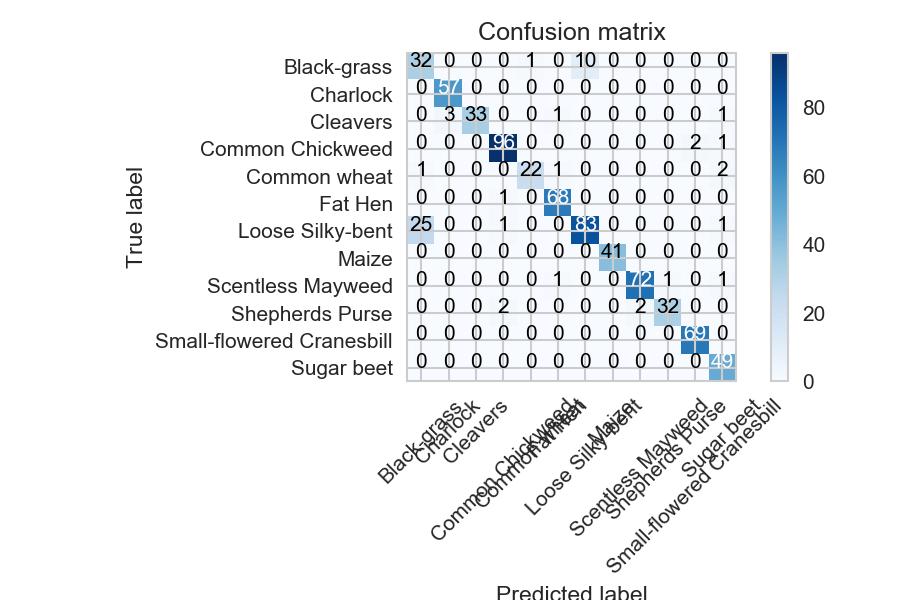

Confusion matrix, without normalization


In [0]:
confusion_diagnostic(model)